In [124]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pmdarima as pm
from functools import reduce
import seaborn as sns

%run Thesis_Model_Function.ipynb

Run Complete: 15/07/2024 21:47:11


In [123]:
%run Thesis_Norway_Data_Prep.ipynb

Run Complete: 15/07/2024 21:47:07
Run Complete: 15/07/2024 21:47:11


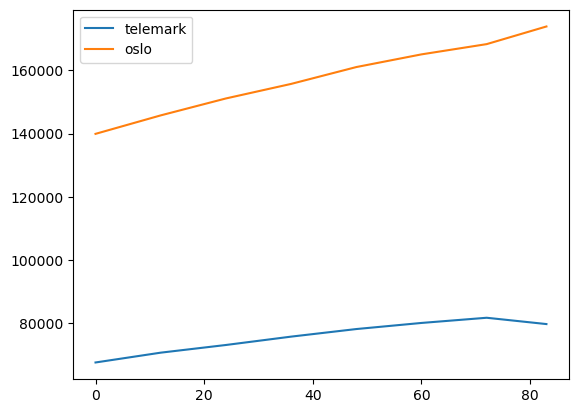

In [76]:
plt.plot(pd.DataFrame(telemark_pop_COVID).iloc[4,:],label = "telemark")
plt.plot(pd.DataFrame(oslo_pop_COVID).iloc[4,:],label = "oslo")
plt.legend()

# tel down , oslo up
# not ostfold, akerhus

## VARMAX Model Selection 

In [30]:
# Model Selection Needed
#  - No Exogenous variables pre COVID period - Best model  5 common, 4 regional , 2 AR , 3 MA 
#  - With Exogenous variables pre-COVID period - Best Model 2 common, 1 regional, 2 AR, 2 MA 28th June

# Not neccessary
#  - No Exogenous variables COVID period - Best Model 2 common, 3 regional, 2 AR, 4 MA
#  - With Exogenous variables COVID period - Best Model 3 common, 3 regional, 2 AR, 2 MA
import numpy as np
import random

train_size = 60 #84
regional_logmort_train = telemark_logmort_full.iloc[:, :train_size]
country_logmort_train = all_nor_logmort.iloc[:, :train_size]
num_iters = 100
common_limit = 5
regional_limit = 5
ar_limit = 6
ma_limit = 6

track_params = np.full((common_limit+1, regional_limit+1, ar_limit+1, ma_limit+1), 0)
error_store = np.full((common_limit+1, regional_limit+1, ar_limit+1, ma_limit+1), np.inf)

for i in range(num_iters):
    # Initialize random parameters
    common_terms = random.randint(1, common_limit)
    regional_terms = random.randint(1, regional_limit)
    ar = random.randint(1, ar_limit)
    ma = random.randint(1, ma_limit)
    
    # Generate new parameters if already used
    while track_params[common_terms, regional_terms, ar, ma] == 1:
        common_terms = random.randint(1, common_limit)
        regional_terms = random.randint(1, regional_limit)
        ar = random.randint(1, ar_limit)
        ma = random.randint(1, ma_limit)
    
    try:
        # Train the model
        track_params[common_terms, regional_terms, ar, ma] = 1
        _, _, _, _, _, _, _, _, _, _, model, _, test_errors,_,_ = VARMAX_model(
            country_logmort_train, regional_logmort_train, 
            common_terms=common_terms, regional_terms=regional_terms, 
            prediction_period=20, train_period=40, AR=ar+1, MA=ma+1,
            
#             exogenous_train=exog_train_telemark, exogenous_test=exog_test_telemark,
#             country_deaths=nor_death, country_pop=nor_pop, 
#             region_deaths=telemark_death, region_pop=telemark_pop,
            
#             exogenous_train=exog_train_telemark_select, exogenous_test=exog_test_telemark_select,
             country_deaths=nor_death_select, country_pop=nor_pop_select, 
             region_deaths=telemark_death_select, region_pop=telemark_pop_select,
            re_est=False)
        print(test_errors)
        # Store the mean of test_errors in the appropriate location
        error_store[common_terms, regional_terms, ar, ma] = np.mean(test_errors) 
    except Exception as e:
        print(f"Error in configuration: AR={ar+1}, MA={ma+1}, Common Terms={common_terms}, Regional Terms={regional_terms}. Error: {str(e)}")
        error_store[common_terms, regional_terms, ar, ma] = np.inf  # Set a large error value
                
    print(f"Configuration {i+1} processed: AR={ar+1}, MA={ma+1}, Common Terms={common_terms}, Regional Terms={regional_terms}, Error={error_store[common_terms, regional_terms, ar, ma]}")

    
    
    
print(np.where(error_store == np.min(error_store)))

Error in configuration: AR=5, MA=2, Common Terms=5, Regional Terms=1. Error: Matrix is not positive definite
Configuration 1 processed: AR=5, MA=2, Common Terms=5, Regional Terms=1, Error=inf
[4.16305244 6.93910853 3.46887559 2.52101285 1.79270958 2.26604634
 3.25406756]
Configuration 2 processed: AR=4, MA=7, Common Terms=5, Regional Terms=1, Error=3.486410412562372
Error in configuration: AR=7, MA=3, Common Terms=5, Regional Terms=1. Error: Matrix is not positive definite
Configuration 3 processed: AR=7, MA=3, Common Terms=5, Regional Terms=1, Error=inf
[3.18403125 4.07809362 2.15983123 1.43961668 1.31373412 1.63519491
 2.70089274]
Configuration 4 processed: AR=4, MA=7, Common Terms=1, Regional Terms=5, Error=2.358770648486254
Error in configuration: AR=7, MA=3, Common Terms=2, Regional Terms=4. Error: Matrix is not positive definite
Configuration 5 processed: AR=7, MA=3, Common Terms=2, Regional Terms=4, Error=inf
[2.77279465 3.41722082 1.8624764  1.36053515 1.20064973 1.60555041
 2.

In [31]:
np.min(error_store)

2.054738389054431

In [40]:
np.min(error_store)

1.3332326645333408

In [30]:
_, _, _, _, _, _, _, _, _, _, model, _, test_errors = VARMAX_model(
                        country_logmort_train, regional_logmort_train, 
                        common_terms=3, regional_terms=3, 
                        prediction_period=20, train_period=40, AR=2, MA=6,
                        #exogenous_train = exog_train_telemark_select,exogenous_test = exog_test_telemark_select,
                        country_deaths = nor_death_select,country_pop=nor_pop_select, region_deaths=telemark_death_select,
                        region_pop=telemark_pop_select, re_est=True)

print(np.mean(test_errors))

1.5196521668187253


## SARIMAX Model Selection

In [123]:
print(f"Lowest Error Configuration: Index: {index}, AR: {ar + 1}, MA: {ma + 1}, Common Terms: {common_terms}, Regional Terms: {regional_terms}")
print(ar+1,ma+1,common_terms,regional_terms)
np.min(error_store)


Lowest Error Configuration: Index: 8, AR: 1, MA: 2, Common Terms: 3, Regional Terms: 3
1 2 3 3


1.2719502016269817

In [7]:
# Model Selection Needed
#  - No Exogenous variables pre COVID period - 2 common 2 regional
#  - With Exogenous variables pre-COVID period - 5 common 1 regional

#  - No Exogenous variables COVID period - 4 common 2 regional
#  - With Exogenous variables COVID period - 4 common 1 regional

train_size =    60 #84
regional_logmort_train = telemark_logmort_incCOVID.iloc[:,:train_size] #telemark_logmort_full.iloc[:,:train_size]
country_logmort_train = all_nor_logmort_incCOVID.iloc[:,:train_size] #all_nor_logmort.iloc[:,:train_size]
exog_train = exog_train_telemark.iloc[:40,] # exog_train_telemark_COVID.iloc[:60,]
exog_test = exog_train_telemark.iloc[40:,] # exog_train_telemark_COVID.iloc[60:,] #exog_train_telemark.iloc[40:,]

error_store = np.zeros((6,6))

for com in range(1,7):
    for reg in range(1,7):
        _,_,_,_,_,_,_,_,_,_,_,regional_predictions,_,_,model_error,res,_,_ = full_model(country_logmort_train,regional_logmort_train,
                                                                                    common_terms = com,regional_terms = reg,
                                                                                    prediction_period = 20,train_period = 40,
                                                                                    exogenous_train = exog_train,exogenous_test = exog_test,
                                                                                    country_deaths = nor_death_select, country_pop = nor_pop_select,
                                                                                    region_deaths = telemark_death_select,region_pop = telemark_pop_select,
                                                                                    
                                                                                    #exogenous_train = exog_train,exogenous_test = exog_test,
                                                                                    #country_deaths=nor_death, country_pop=nor_pop, 
                                                                                    #region_deaths=telemark_death, region_pop=telemark_pop,
                                                                                    re_est = False,smooth = False) 
        
        regional_predictions = pd.DataFrame(regional_predictions)
        regional_predictions.index = regional_logmort_train.index
        regional_predictions.columns = regional_logmort_train.columns
        
        errors = MAPE(regional_predictions.iloc[:,40:],regional_logmort_train.iloc[:,40:])
        error_store[com-1,reg-1] = np.mean(errors)
        
        
        
print(error_store)

Common k_t0 is white noise with LB p_value 0.21618966365101314
p_value k_t0 before re-estimation: 0.8515713074796066 

Regional k_t0 is white noise with LB p_value 0.8515713074796066 

p_value k_t0 after re-estimation: 0.8515713074796066 

Regional k_t0 is white noise with LB p_value 0.8515713074796066 

Common k_t0 is white noise with LB p_value 0.21618966365101314
p_value k_t0 before re-estimation: 0.8515713074796066 

Regional k_t0 is white noise with LB p_value 0.8515713074796066 

p_value k_t1 before re-estimation: 0.3630947840803844 

Regional k_t1 is white noise with LB p_value 0.3630947840803844 

p_value k_t0 after re-estimation: 0.8515713074796066 

Regional k_t0 is white noise with LB p_value 0.8515713074796066 

p_value k_t1 after re-estimation: 0.3630947840803844 

Regional k_t1 is white noise with LB p_value 0.3630947840803844 

Common k_t0 is white noise with LB p_value 0.21618966365101314
p_value k_t0 before re-estimation: 0.8515713074796066 

Regional k_t0 is white noi

## SARIMAX Models

# Testing model with no common parameters

In [111]:
# Model Selection Needed
#  - No Exogenous variables pre COVID period - 4 Regional
#  - With Exogenous variables pre-COVID period - 4 Regional  
#  - No Exogenous variables COVID period - 1 Regional
#  - With Exogenous variables COVID period 4 Regional

train_size =   60 # 84
regional_logmort_train = telemark_logmort_incCOVID.iloc[:,:train_size] #telemark_logmort_full.iloc[:,:train_size]
country_logmort_train = all_nor_logmort_incCOVID.iloc[:,:train_size] #all_nor_logmort.iloc[:,:train_size]
exog_train = exog_train_telemark.iloc[:40,] # exog_train_telemark_COVID.iloc[:60,] #exog_train_telemark.iloc[:40,]
exog_test = exog_train_telemark.iloc[40:,] #exog_train_telemark_COVID.iloc[60:,] #exog_train_telemark.iloc[40:,]

error_store = np.zeros((2,6))

for com in range(1,3):
    for reg in range(1,7):
        
        if com == 1:
            smth = True
        else:
            smth = False
        _,_,_,_,_,_,regional_predictions,_,_,model_error,res,_ = model_no_common(regional_logmort_train,
                                                                               regional_terms = reg,
                                                                               prediction_period = 20,train_period = 40,
                                                                               region_deaths = telemark_death,region_pop = telemark_pop,
                                                                               exogenous_train = exog_train,exogenous_test = exog_test,
                                                                               re_est = False,smooth = smth)
 
        
        regional_predictions = pd.DataFrame(regional_predictions)
        regional_predictions.index = regional_logmort_train.index
        regional_predictions.columns = regional_logmort_train.columns
        
        errors = MAPE(regional_predictions.iloc[:,40:],regional_logmort_train.iloc[:,40:])
        error_store[com-1,reg-1] = np.mean(errors)
        
        
        
print(error_store)

p_value k_t0 before re-estimation: 4.472504325185987e-06 

Proportion of k_t values which are positive[0.55] 

Proportion of b_x values which are positive[0.28571429] 

p_value k_t0 after re-estimation: 0.010700937123286711 

p_value k_t0 before re-estimation: 4.472504325185987e-06 

p_value k_t1 before re-estimation: 3.2677826839244085e-05 

Proportion of k_t values which are positive[0.55 0.45] 

Proportion of b_x values which are positive[0.28571429 0.28571429] 

p_value k_t0 after re-estimation: 0.010700937123286711 

p_value k_t1 after re-estimation: 0.01723650441291369 

p_value k_t0 before re-estimation: 4.472504325185987e-06 

p_value k_t1 before re-estimation: 3.2677826839244085e-05 

p_value k_t2 before re-estimation: 2.5764497487736368e-23 

Proportion of k_t values which are positive[0.55  0.45  0.525] 

Proportion of b_x values which are positive[0.28571429 0.28571429 0.57142857] 

p_value k_t0 after re-estimation: 0.010700937123286711 

p_value k_t1 after re-estimation: 0

KeyboardInterrupt: 

p_value k_t0 before re-estimation: 0.4025694770098003 

Regional k_t0 is white noise with LB p_value 0.4025694770098003 

p_value k_t1 before re-estimation: 0.5557235483797726 

Regional k_t1 is white noise with LB p_value 0.5557235483797726 

p_value k_t2 before re-estimation: 0.020714336864991502 

p_value k_t3 before re-estimation: 3.0165233622079076e-35 

Proportion of k_t values which are positive[0.4        0.53333333 0.53333333 0.46666667] 

Proportion of b_x values which are positive[0.57142857 0.85714286 0.28571429 0.28571429] 

p_value k_t0 after re-estimation: 0.43323373946734717 

Regional k_t0 is white noise with LB p_value 0.43323373946734717 

p_value k_t1 after re-estimation: 0.7226567601679652 

Regional k_t1 is white noise with LB p_value 0.7226567601679652 

p_value k_t2 after re-estimation: 0.029331283441831307 

p_value k_t3 after re-estimation: 5.8059031826461554e-11 

Model Error 11.195321932355942
Re_estimation error Each Age Group (MAPE): [0.0358818  0.0354042 

<Figure size 640x480 with 0 Axes>

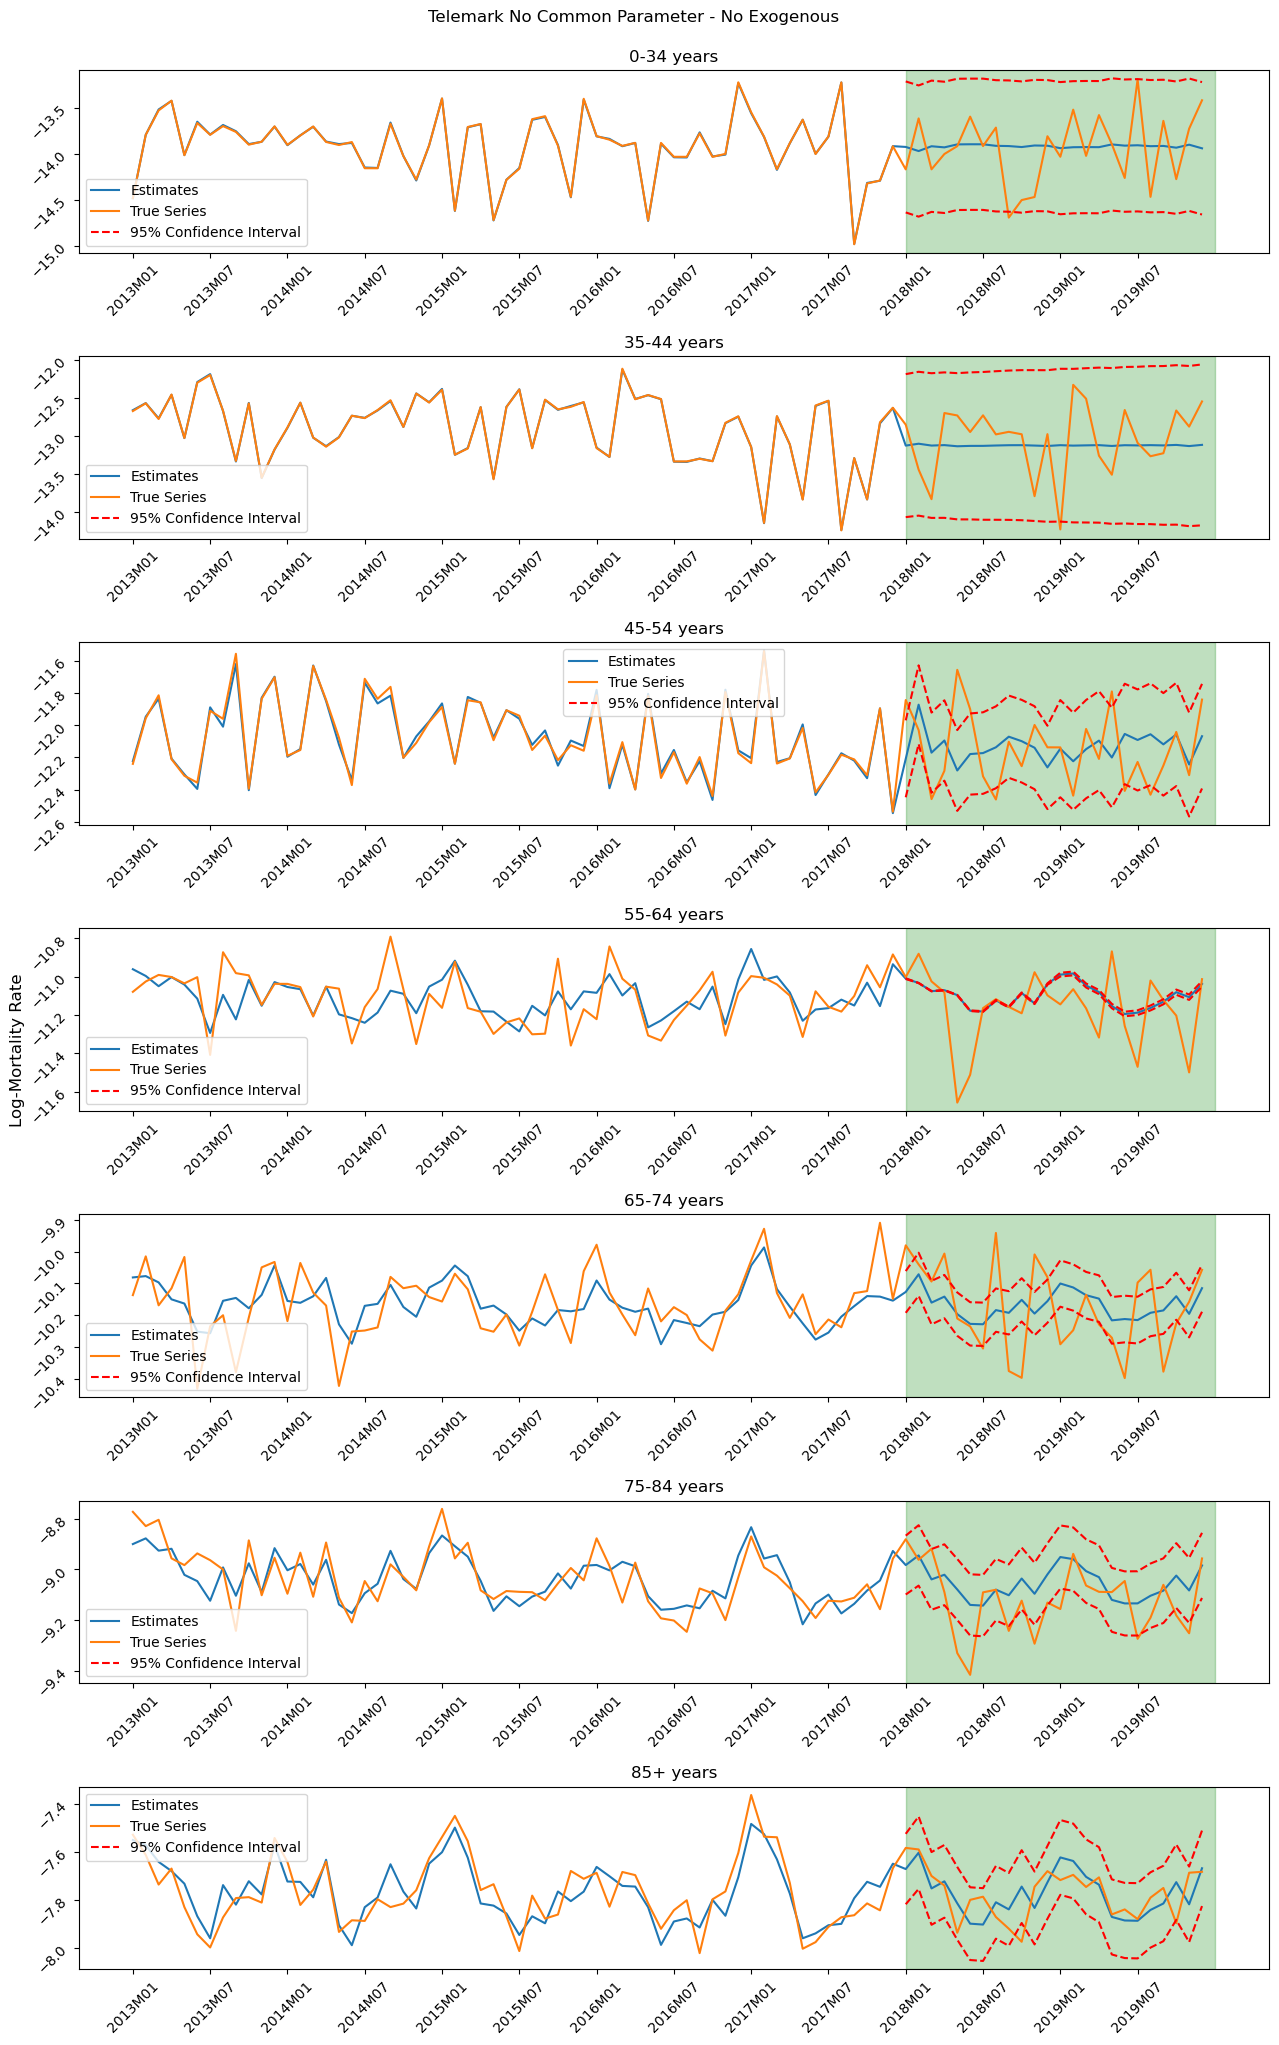

In [120]:
## Model No Common parameter - No Exogenous
a_xi,b_xs,k_ts,regional_re_est,k_t_models,k_t_preds,regional_predictions_nocommout,regional_predictions_upconf,regional_predictions_lowconf,model_error,res,_ = model_no_common(telemark_logmort_full,regional_terms = 4,prediction_period = 24,train_period = 60,region_deaths = telemark_death,region_pop = telemark_pop,re_est = False,smooth = False)

#exogenous_train = exog_train_telemark,exogenous_test = exog_test_telemark
regional_predictions_nocommout = pd.DataFrame(regional_predictions_nocommout)
regional_predictions_upconf = pd.DataFrame(regional_predictions_upconf)
regional_predictions_lowconf = pd.DataFrame(regional_predictions_lowconf)

regional_predictions_nocommout.index = telemark_logmort_full.index
regional_predictions_nocommout.columns = telemark_logmort_full.columns
regional_predictions_upconf.index = telemark_logmort_full.index
regional_predictions_upconf.columns = telemark_logmort_full.columns
regional_predictions_lowconf.index = telemark_logmort_full.index
regional_predictions_lowconf.columns = telemark_logmort_full.columns

print("Model Error " + str(model_error))
print("Re_estimation error Each Age Group (MAPE): "+str(MAPE(regional_predictions_nocommout.iloc[:,:60],telemark_logmort_full.iloc[:,:60])))

#AIC_values = [K_t_models["model_0"].aic(),K_t_models["model_1"].aic(),k_t_models["model_0"].aic(),k_t_models["model_1"].aic()]
#print("\n Model AIC Values [K_t1,K_t2,k_t1,k_t2]: \n"+ str(AIC_values))

print("\n Prediction Error Each Age Group (MAPE)" +str(MAPE(regional_predictions_nocommout.iloc[:,60:],telemark_logmort_full.iloc[:,60:])))
print(k_t_models["model_0"].summary())

error_NoCom_wout = MAPE(regional_predictions_nocommout.iloc[:,60:],telemark_logmort_full.iloc[:,60:])
prediction_plots(regional_predictions_nocommout,regional_predictions_upconf,regional_predictions_lowconf,24,telemark_logmort_full,suptitle = "Telemark No Common Parameter - No Exogenous")
 


In [121]:
print(k_t_models['model_0'].summary())
print(k_t_models['model_1'].summary())
print(k_t_models['model_2'].summary())
print(k_t_models['model_3'].summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   60
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  36.271
Date:                Mon, 15 Jul 2024   AIC                            -68.542
Time:                        14:40:24   BIC                            -64.387
Sample:                             0   HQIC                           -66.920
                                 - 60                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8927      0.071    -12.645      0.000      -1.031      -0.754
sigma2         0.0167      0.003      5.264      0.000       0.010       0.023
Ljung-Box (L1) (Q):                   0.03   Jarque-

p_value k_t0 before re-estimation: 0.3417535540843586 

Regional k_t0 is white noise with LB p_value 0.3417535540843586 

p_value k_t1 before re-estimation: 0.5761068431745566 

Regional k_t1 is white noise with LB p_value 0.5761068431745566 

p_value k_t2 before re-estimation: 0.0006587658586772866 

p_value k_t3 before re-estimation: 1.2458660913221176e-24 

Proportion of k_t values which are positive[0.4        0.53333333 0.53333333 0.5       ] 

Proportion of b_x values which are positive[0.57142857 0.85714286 0.28571429 0.28571429] 

p_value k_t0 after re-estimation: 0.43323373946734717 

Regional k_t0 is white noise with LB p_value 0.43323373946734717 

p_value k_t1 after re-estimation: 0.787940672622254 

Regional k_t1 is white noise with LB p_value 0.787940672622254 

p_value k_t2 after re-estimation: 0.029331283441831307 

p_value k_t3 after re-estimation: 1.6594926476193497e-07 

Model Error 15.618174739545376
Re_estimation error Each Age Group (MAPE): [0.05053156 0.0481848  

<Figure size 640x480 with 0 Axes>

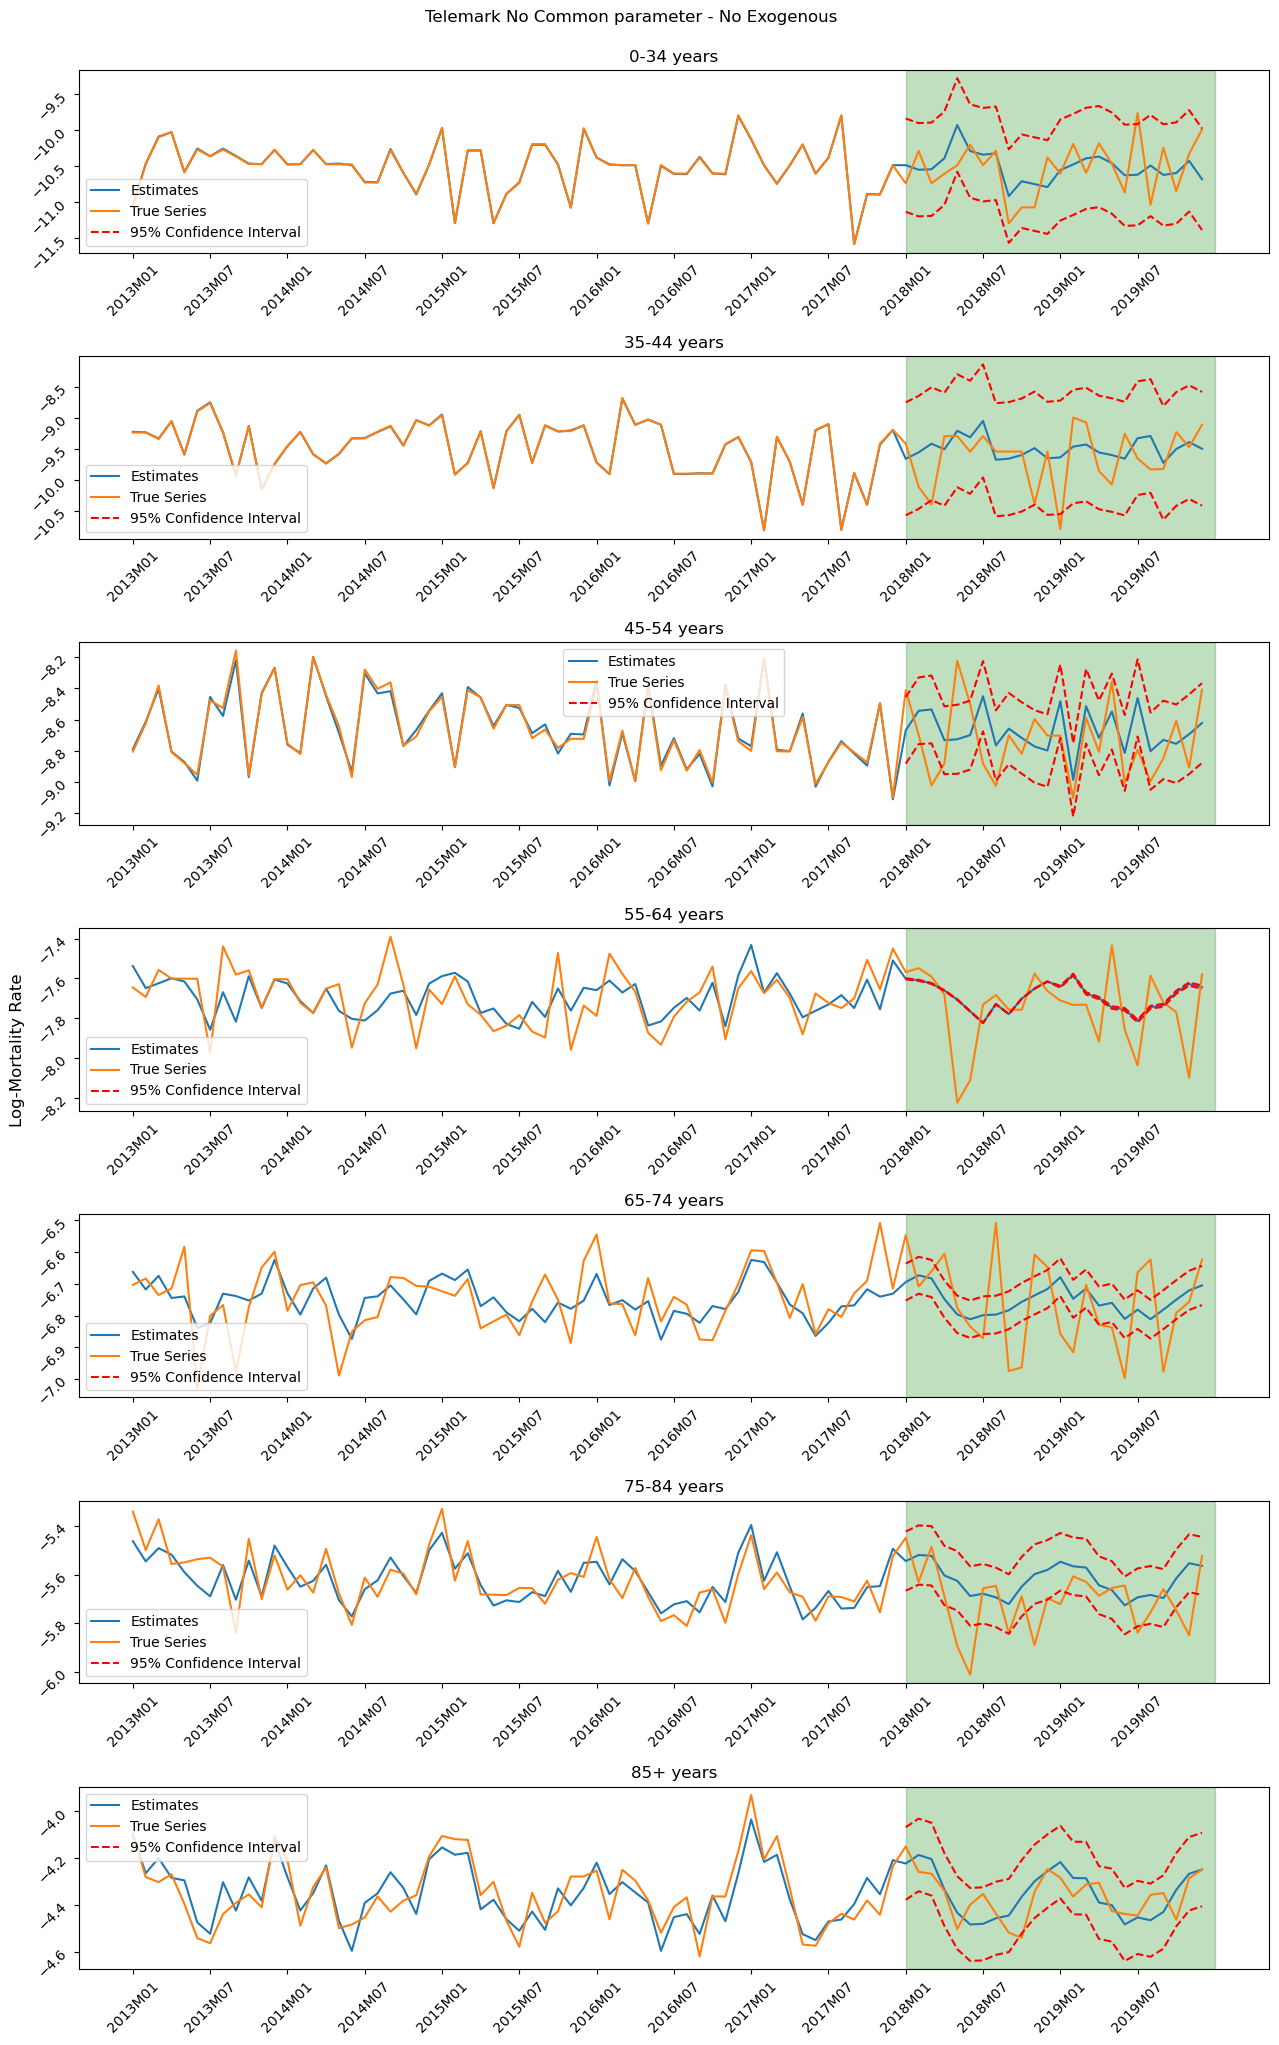

In [117]:
## Model No Common parameter - with Exogenous
a_xi,b_xs,k_ts,regional_re_est,k_t_models,k_t_preds,regional_predictions_nocommwith,regional_predictions_upconf,regional_predictions_lowconf,model_error,res,_ = model_no_common(telemark_logmort_full,regional_terms = 4,prediction_period = 24,train_period = 60,exogenous_train = exog_train_telemark,exogenous_test = exog_test_telemark,region_deaths = telemark_death,region_pop = telemark_pop,re_est = False,smooth = False)

#exogenous_train = exog_train_telemark,exogenous_test = exog_test_telemark
regional_predictions_nocommwith = pd.DataFrame(regional_predictions_nocommwith)
regional_predictions_upconf = pd.DataFrame(regional_predictions_upconf)
regional_predictions_lowconf = pd.DataFrame(regional_predictions_lowconf)

regional_predictions_nocommwith.index = telemark_logmort_full.index
regional_predictions_nocommwith.columns = telemark_logmort_full.columns
regional_predictions_upconf.index = telemark_logmort_full.index
regional_predictions_upconf.columns = telemark_logmort_full.columns
regional_predictions_lowconf.index = telemark_logmort_full.index
regional_predictions_lowconf.columns = telemark_logmort_full.columns

print("Model Error " + str(model_error))
print("Re_estimation error Each Age Group (MAPE): "+str(MAPE(regional_predictions_nocommwith.iloc[:,:60],telemark_logmort_full.iloc[:,:60])))

#AIC_values = [K_t_models["model_0"].aic(),K_t_models["model_1"].aic(),k_t_models["model_0"].aic(),k_t_models["model_1"].aic()]
#print("\n Model AIC Values [K_t1,K_t2,k_t1,k_t2]: \n"+ str(AIC_values))

print("\n Prediction Error Each Age Group (MAPE)" +str(MAPE(regional_predictions_nocommwith.iloc[:,60:],telemark_logmort_full.iloc[:,60:])))
print(k_t_models["model_0"].summary())

error_NoCom_with = MAPE(regional_predictions_nocommwith.iloc[:,60:],telemark_logmort_full.iloc[:,60:])
prediction_plots(regional_predictions_nocommwith,regional_predictions_upconf,regional_predictions_lowconf,24,telemark_logmort_full,suptitle = "Telemark No Common parameter - No Exogenous ")



In [28]:
print(k_t_models['model_0'].summary())
print(k_t_models['model_1'].summary())
print(k_t_models['model_2'].summary())
print(k_t_models['model_3'].summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   60
Model:                        SARIMAX   Log Likelihood                  41.079
Date:                Mon, 08 Jul 2024   AIC                            -70.157
Time:                        23:58:39   BIC                            -57.591
Sample:                             0   HQIC                           -65.242
                                 - 60                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
av_temp        0.0134      0.007      2.040      0.041       0.001       0.026
av_humid      -0.0008      0.001     -1.122      0.262      -0.002       0.001
temp_below     0.0081      0.006      1.420      0.1

# SARIMAX Models pre-COVID With Common terms

Common k_t2 is white noise with LB p_value 0.8983366501621827
Common k_t3 is white noise with LB p_value 0.16801159481305192
p_value k_t0 before re-estimation: 0.4453191104973618 

Regional k_t0 is white noise with LB p_value 0.4453191104973618 

p_value k_t1 before re-estimation: 0.41297323937085617 

Regional k_t1 is white noise with LB p_value 0.41297323937085617 

p_value k_t0 after re-estimation: 0.4453191104973618 

Regional k_t0 is white noise with LB p_value 0.4453191104973618 

p_value k_t1 after re-estimation: 0.41297323937085567 

Regional k_t1 is white noise with LB p_value 0.41297323937085567 

Model Error 7.409263223546135
Re_estimation error Each Age Group (MAPE): [0.06432885 0.11015158 1.9917521  1.40752643 1.06491659 1.0355784
 1.42693405]

 Prediction Error Each Age Group (MAPE)[2.68744721 3.93190706 2.19222996 1.80409674 1.78289812 1.83554493
 1.75972765]


<Figure size 640x480 with 0 Axes>

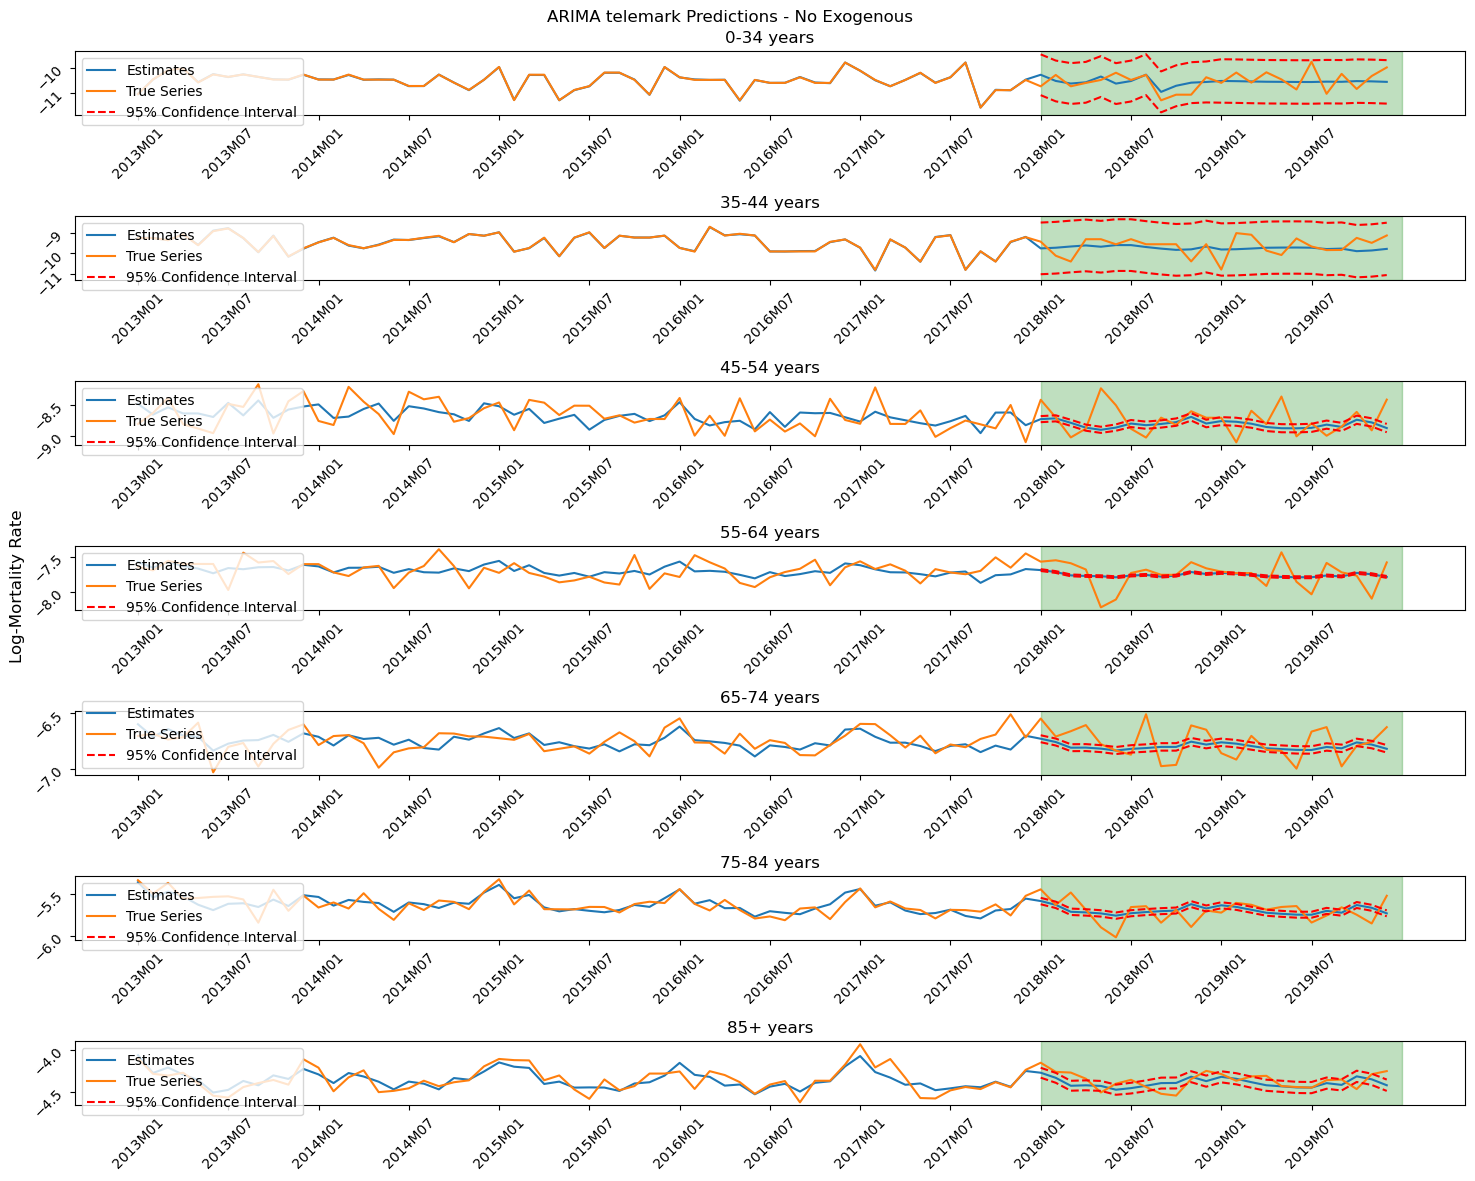

In [81]:
### Without Exogenous
a_xi,B_xs,K_ts,b_xs,k_ts,country_re_est,regional_re_est,K_t_models,k_t_models,K_t_preds,k_t_preds,regional_predictions_sarout,regional_predictions_upconf,regional_predictions_lowconf,model_error,res,_,_ = full_model(all_nor_logmort,telemark_logmort_full, common_terms = 4,regional_terms = 2,prediction_period = 24,train_period = 60,country_deaths = nor_death, country_pop = nor_pop,region_deaths = telemark_death,region_pop = telemark_pop,re_est = False,smooth = False)  


regional_predictions_sarout = pd.DataFrame(regional_predictions_sarout)
regional_predictions_upconf = pd.DataFrame(regional_predictions_upconf)
regional_predictions_lowconf = pd.DataFrame(regional_predictions_lowconf)

regional_predictions_sarout.index = telemark_logmort_full.index
regional_predictions_sarout.columns = telemark_logmort_full.columns
regional_predictions_upconf.index = telemark_logmort_full.index
regional_predictions_upconf.columns = telemark_logmort_full.columns
regional_predictions_lowconf.index = telemark_logmort_full.index
regional_predictions_lowconf.columns = telemark_logmort_full.columns

print("Model Error " + str(model_error))
print("Re_estimation error Each Age Group (MAPE): "+str(MAPE(regional_predictions_sarout.iloc[:,:60],telemark_logmort_full.iloc[:,:60])))

#AIC_values = [K_t_models["model_0"].aic(),K_t_models["model_1"].aic(),k_t_models["model_0"].aic(),k_t_models["model_1"].aic()]
#print("\n Model AIC Values [K_t1,K_t2,k_t1,k_t2]: \n"+ str(AIC_values))

print("\n Prediction Error Each Age Group (MAPE)" +str(MAPE(regional_predictions_sarout.iloc[:,60:],telemark_logmort_full.iloc[:,60:])))

error_SARIMAX_wout = MAPE(regional_predictions_sarout.iloc[:,60:],telemark_logmort_full.iloc[:,60:])
prediction_plots(regional_predictions_sarout,regional_predictions_upconf,regional_predictions_lowconf,24,telemark_logmort_full,suptitle = "ARIMA telemark Predictions - No Exogenous")



In [57]:
for mod in K_t_models.keys():
    print(str(K_t_models[mod].get_params()["order"]) + str(K_t_models[mod].get_params()["seasonal_order"]))
    
print("-")

for mod in k_t_models.keys():
    print(str(k_t_models[mod].get_params()["order"]) + str(k_t_models[mod].get_params()["seasonal_order"]))
 



(0, 0, 1)(1, 1, 0, 12)
-
(1, 0, 0)(0, 0, 0, 12)
(0, 0, 0)(2, 0, 0, 12)
(2, 1, 1)(2, 0, 0, 12)
(5, 1, 0)(0, 0, 0, 12)
(0, 0, 0)(0, 0, 0, 12)


Common k_t2 is white noise with LB p_value 0.8983366501621827
Common k_t3 is white noise with LB p_value 0.16801159481305192
p_value k_t0 before re-estimation: 0.45659920799216236 

Regional k_t0 is white noise with LB p_value 0.45659920799216236 

p_value k_t0 after re-estimation: 0.45659920799216186 

Regional k_t0 is white noise with LB p_value 0.45659920799216186 

Re_estimation error Each Age Group (MAPE): [2.29334862 0.12843147 2.01854357 1.33590612 1.07421323 1.03243642
 1.24342566]

 Prediction Error Each Age Group (MAPE)[2.91088195 3.99288298 2.16280836 1.98321571 1.7982667  1.86091735
 1.68116188]


<Figure size 640x480 with 0 Axes>

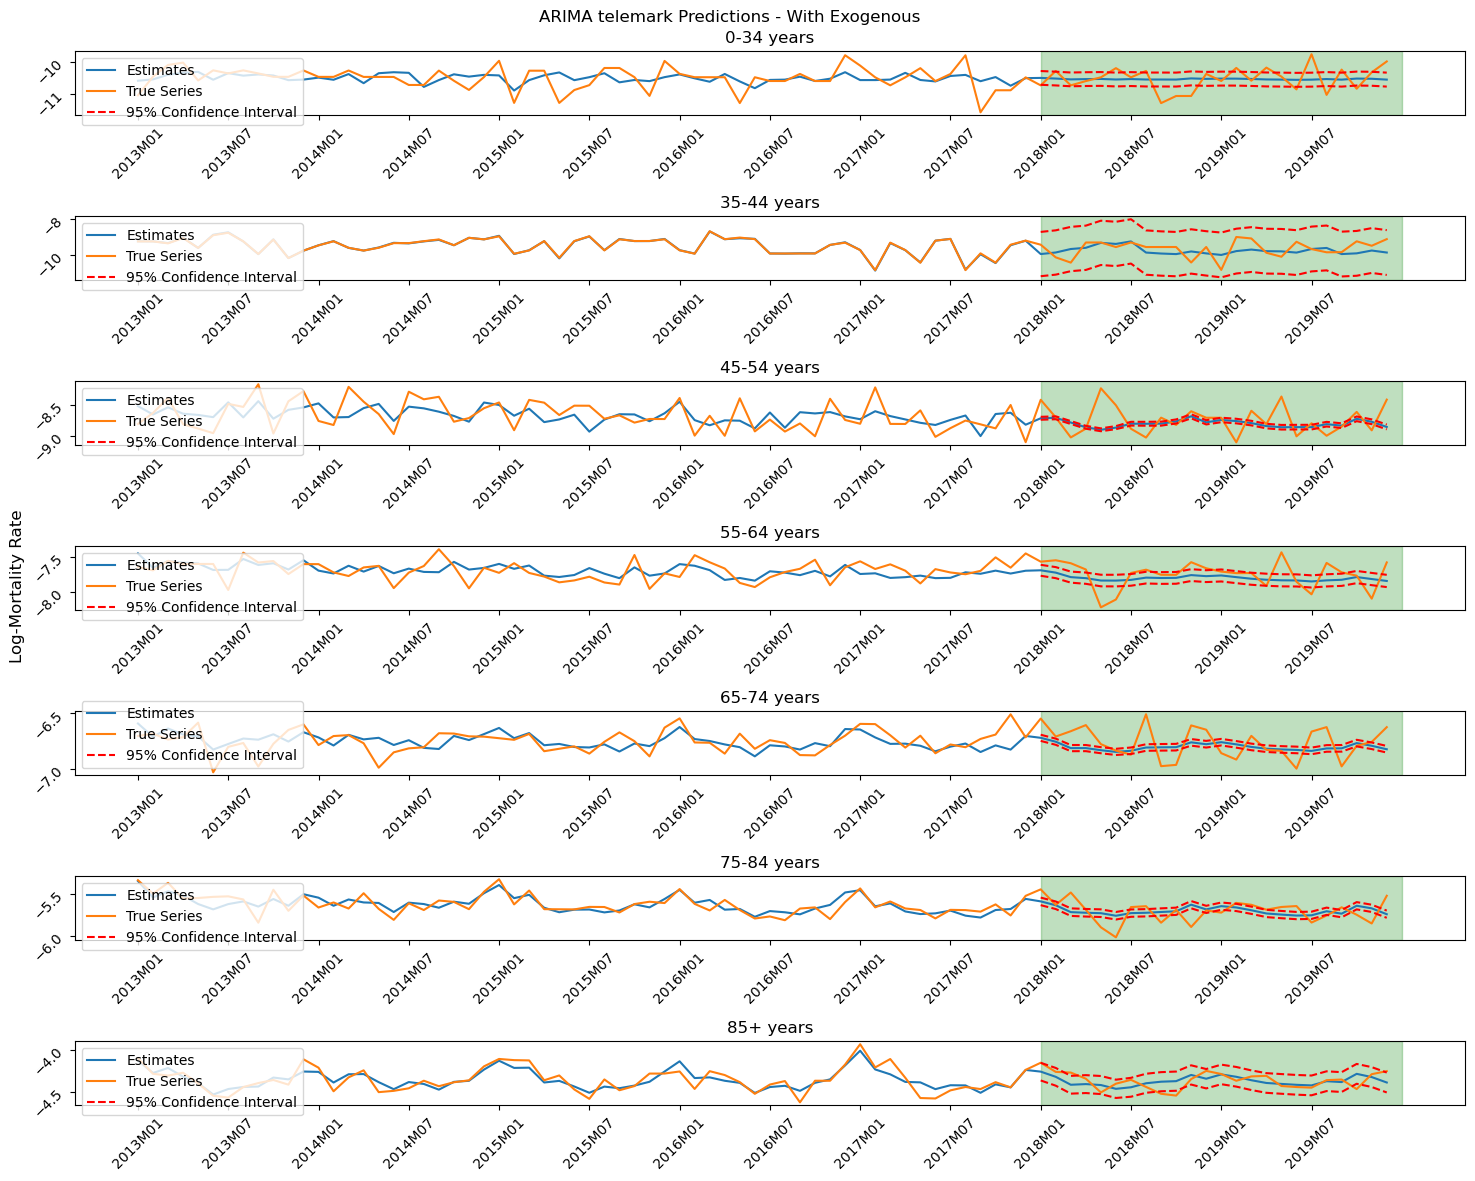

In [82]:
### With Exogenous
a_xi,B_xs,K_ts,b_xs,k_ts,country_re_est,regional_re_est,K_t_models,k_t_models,K_t_preds,k_t_preds,regional_predictions_sarwith,regional_predictions_upconf,regional_predictions_lowconf,model_error,res,_,_ = full_model(all_nor_logmort,telemark_logmort_full, common_terms = 5,regional_terms = 1,prediction_period = 24,train_period = 60,exogenous_train = exog_train_telemark,exogenous_test = exog_test_telemark,country_deaths = nor_death, country_pop = nor_pop,region_deaths = telemark_death,region_pop = telemark_pop,re_est = False,smooth=False)  


regional_predictions_sarwith = pd.DataFrame(regional_predictions_sarwith)
regional_predictions_upconf = pd.DataFrame(regional_predictions_upconf)
regional_predictions_lowconf = pd.DataFrame(regional_predictions_lowconf)

regional_predictions_sarwith.index = telemark_logmort_full.index
regional_predictions_sarwith.columns = telemark_logmort_full.columns
regional_predictions_upconf.index = telemark_logmort_full.index
regional_predictions_upconf.columns = telemark_logmort_full.columns
regional_predictions_lowconf.index = telemark_logmort_full.index
regional_predictions_lowconf.columns = telemark_logmort_full.columns

print("Re_estimation error Each Age Group (MAPE): "+str(MAPE(regional_predictions_sarwith.iloc[:,:60],telemark_logmort_full.iloc[:,:60])))

#AIC_values = [K_t_models["model_0"].aic(),K_t_models["model_1"].aic(),k_t_models["model_0"].aic(),k_t_models["model_1"].aic()]
#print("\n Model AIC Values [K_t1,K_t2,k_t1,k_t2]: \n"+ str(AIC_values))

print("\n Prediction Error Each Age Group (MAPE)" +str(MAPE(regional_predictions_sarwith.iloc[:,60:],telemark_logmort_full.iloc[:,60:])))

#print(str(k_t_models["model_0"].summary()))
#print(k_t_models["model_1"].summary())
error_SARIMAX_w= MAPE(regional_predictions_sarwith.iloc[:,60:],telemark_logmort_full.iloc[:,60:])

prediction_plots(regional_predictions_sarwith,regional_predictions_upconf,regional_predictions_lowconf,24,telemark_logmort_full,suptitle = "ARIMA telemark Predictions - With Exogenous")



In [60]:
for mod in K_t_models.keys():
    print(str(K_t_models[mod].get_params()["order"]) + str(K_t_models[mod].get_params()["seasonal_order"]))
    
print("-")

for mod in k_t_models.keys():
    print(str(k_t_models[mod].get_params()["order"]) + str(k_t_models[mod].get_params()["seasonal_order"]))
 



(0, 0, 1)(1, 1, 0, 12)
-
(0, 0, 0)(0, 0, 0, 12)


## VARMAX Models

test_errors[2.92121608 4.87938485 3.92932765 1.87191779 1.8507165  1.78617013
 1.97775004]


<Figure size 640x480 with 0 Axes>

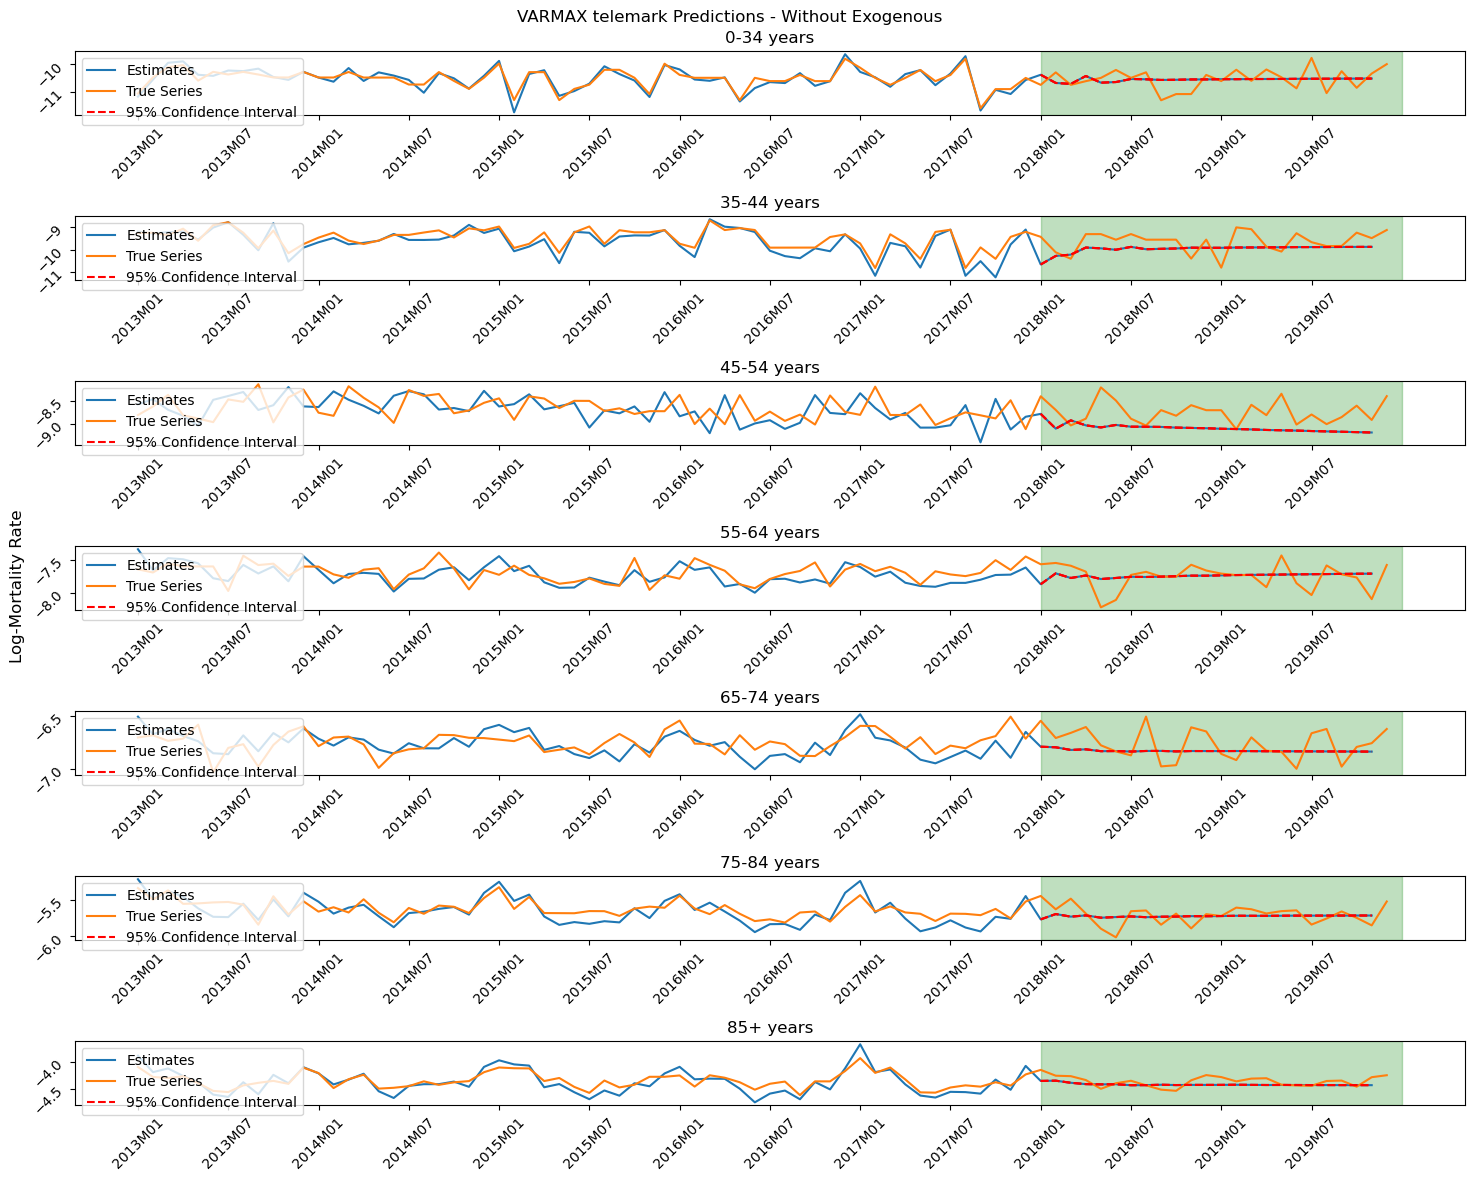

In [83]:
### Without Exogenous
all_k_t, K_ts,k_ts,B_xs,b_xs,a_xi,all_k_preds,predictions_varout,predictions_lowconf,predictions_upconf,model_VAR_wout,aic,error_VAR_wout,_,_ = VARMAX_model(all_nor_logmort,telemark_logmort_full, common_terms = 5,regional_terms = 4,prediction_period = 24,train_period = 60,AR= 2,MA = 3,country_deaths = nor_death,country_pop = nor_pop,region_deaths = telemark_death,region_pop = telemark_pop,re_est = False,smooth = False)

print("test_errors" + str(error_VAR_wout))
prediction_plots(predictions_varout,predictions_varout,predictions_varout,24,telemark_logmort_full,suptitle = "VARMAX telemark Predictions - Without Exogenous")



test_errors[2.81079115 4.0525551  2.20992299 1.65222074 1.66571247 1.81231792
 1.1971629 ]


<Figure size 640x480 with 0 Axes>

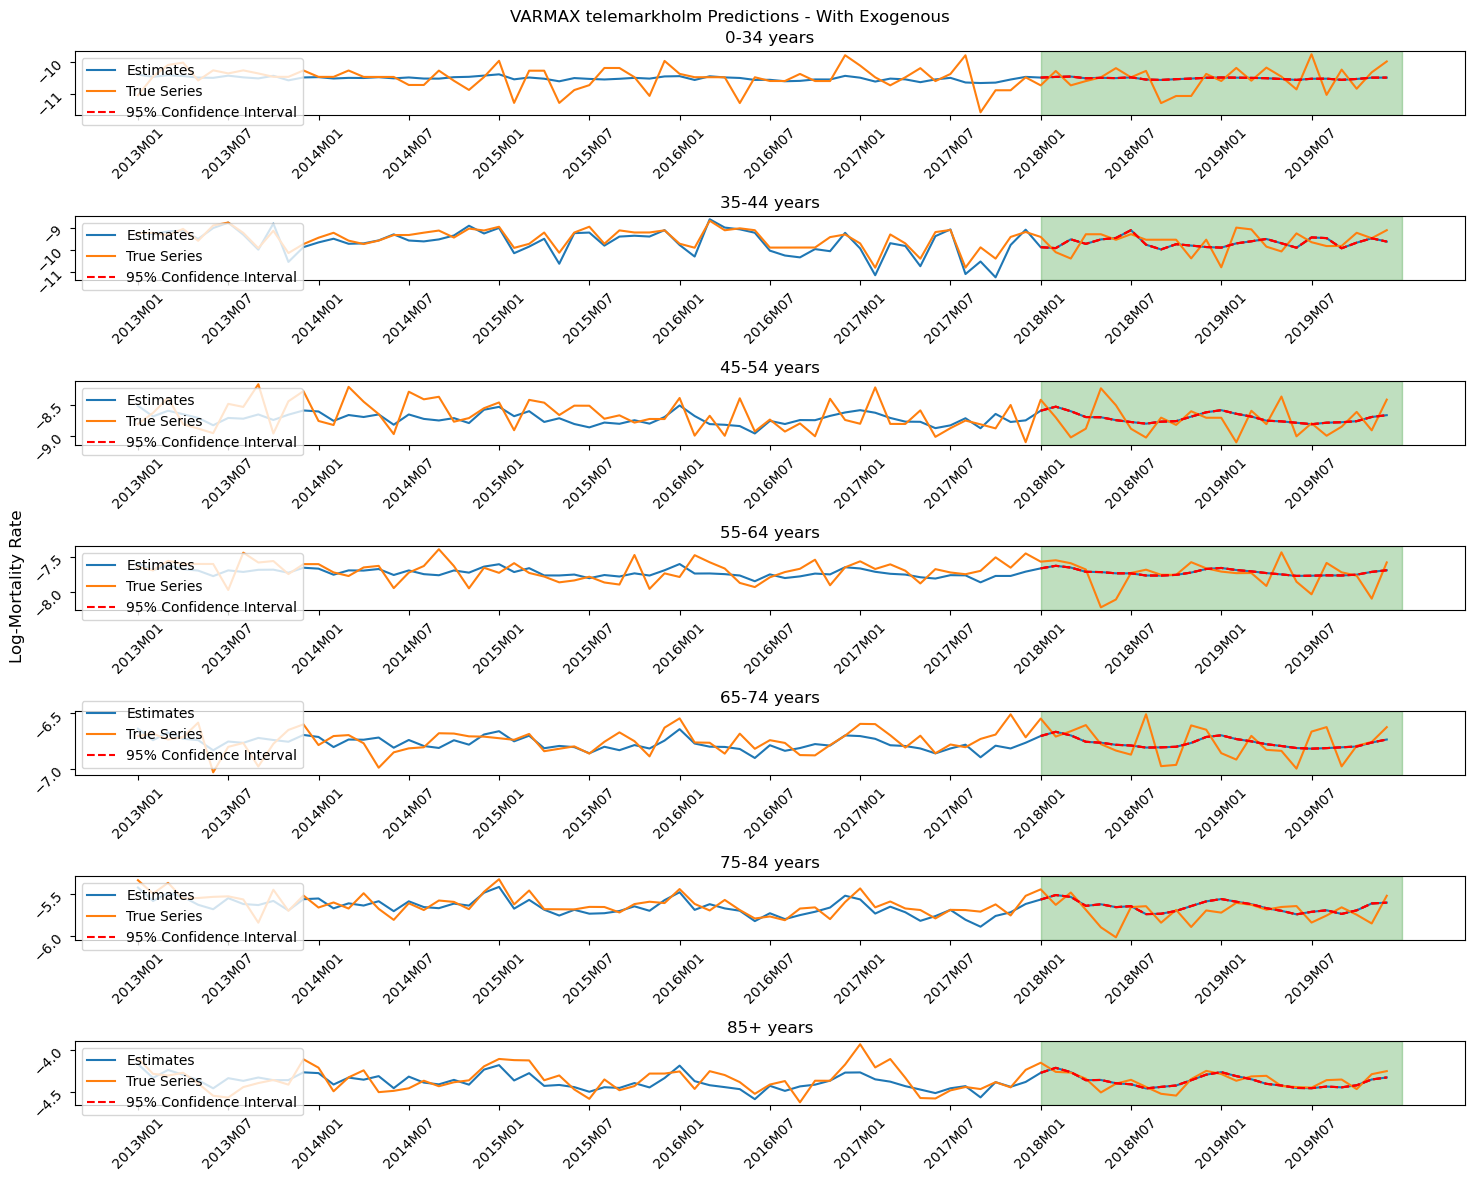

In [84]:
### With Exogenous
all_k_t, K_ts,k_ts,B_xs,b_xs,a_xi,all_k_preds,predictions_varwith,predictions_lowconf,predictions_upconf,model_VAR_with,aic,error_VAR_w,_,_ = VARMAX_model(all_nor_logmort,telemark_logmort_full, common_terms = 2,regional_terms = 1,prediction_period = 24,train_period = 60,AR= 2,MA = 2,exogenous_train = exog_train_telemark,exogenous_test = exog_test_telemark,country_deaths = nor_death,country_pop = nor_pop,region_deaths = telemark_death,region_pop = telemark_pop,re_est = False)

print("test_errors" + str(error_VAR_w))
prediction_plots(predictions_varwith,predictions_varwith,predictions_varwith,24,telemark_logmort_full,suptitle = "VARMAX telemarkholm Predictions - With Exogenous")



In [29]:
model_VAR_with.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:              [0, 1, 2]   No. Observations:                   60
Model:                    VARMAX(2,2)   Log Likelihood                 104.061
                          + intercept   AIC                            -88.121
Date:                Fri, 28 Jun 2024   BIC                             37.540
Time:                        17:03:45   HQIC                           -38.968
Sample:                             0                                         
                                 - 60                                         
Covariance Type:                  opg                                         
===================================================================================
Ljung-Box (L1) (Q):       0.27, 0.12, 0.08   Jarque-Bera (JB):     0.18, 2.38, 0.03
Prob(Q):                  0.61, 0.73, 0.77   Prob(JB):             0.92, 0.30, 0.98
Heteroskedasticity (H):   1.29, 1.73, 2.48   Skew:               -0.03, -0.48, 0.03
Prob(H) (two-sided):      0.57, 0.23, 0.05   Kurtosis:             3.26, 3.22, 3.10
                               Results for equation 0                              
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept          -0.2443      1.200     -0.204      0.839      -2.597       2.108
L1.0                0.0323     12.368      0.003      0.998     -24.209      24.274
L1.1               -0.0902      2.030     -0.044      0.965      -4.069       3.888
L1.2                0.2446      0.804      0.304      0.761      -1.331       1.820
L2.0               -0.0838     15.481     -0.005      0.996     -30.425      30.258
L2.1                0.0112      5.128      0.002      0.998     -10.040      10.063
L2.2                0.2432     12.868      0.019      0.985     -24.977      25.464
L1.e(0)            -0.0566     15.590     -0.004      0.997     -30.612      30.499
L1.e(1)            -0.0506      1.564     -0.032      0.974      -3.115       3.014
L1.e(2)             0.1088      3.339      0.033      0.974      -6.436       6.654
L2.e(0)             0.0202     21.122      0.001      0.999     -41.378      41.419
L2.e(1)             0.0232     12.061      0.002      0.998     -23.615      23.662
L2.e(2)            -0.0242     15.560     -0.002      0.999     -30.521      30.473
beta.av_temp        0.0115      0.088      0.130      0.897      -0.162       0.185
beta.av_humid       0.0027      0.026      0.103      0.918      -0.048       0.054
beta.temp_below     0.0007      0.069      0.010      0.992      -0.135       0.137
beta.temp_above    -0.0050      0.093     -0.054      0.957      -0.188       0.178
beta.hols          -0.0012      0.083     -0.015      0.988      -0.164       0.162
                               Results for equation 1                              
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept          -0.1458      3.712     -0.039      0.969      -7.422       7.130
L1.0                0.0493     39.168      0.001      0.999     -76.718      76.816
L1.1                0.0596      2.041      0.029      0.977      -3.941       4.060
L1.2                0.0492      4.981      0.010      0.992      -9.714       9.812
L2.0               -0.4303     14.035     -0.031      0.976     -27.938      27.077
L2.1               -0.0059      3.330     -0.002      0.999      -6.532       6.520
L2.2                0.1751      8.100      0.022      

In [16]:
all_nor_logmort.index

Index(['0-34 years', '35-44 years', '45-54 years', '55-64 years',
       '65-74 years', '75-84 years', '85+ years'],
      dtype='object', name='Age_band')

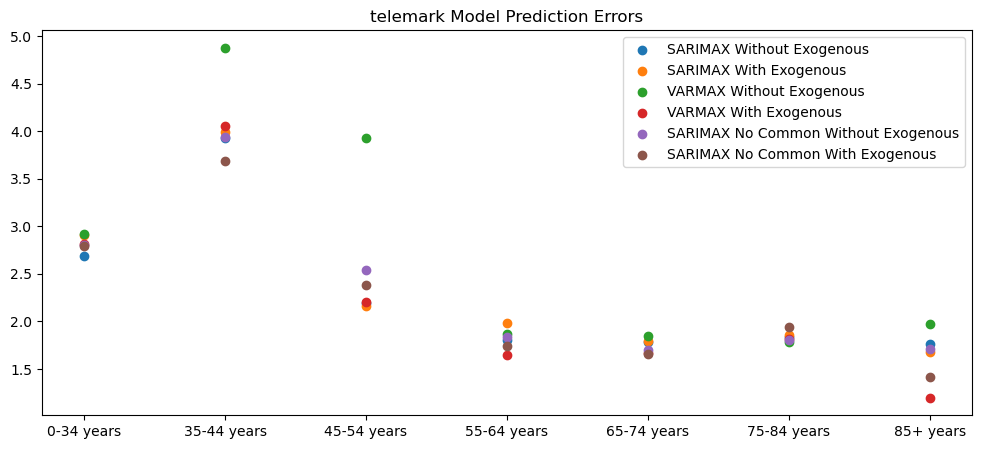

In [85]:
test_errors = np.vstack((error_SARIMAX_wout,error_SARIMAX_w,error_VAR_wout,error_VAR_w,error_NoCom_wout,error_NoCom_with))
telemark = test_errors

age_groups = all_nor_logmort.index
plt.figure(figsize = (12,5))
plt.scatter(age_groups,telemark[0,:],label = "SARIMAX Without Exogenous")
plt.scatter(age_groups,telemark[1,:],label = "SARIMAX With Exogenous")
plt.scatter(age_groups,telemark[2,:],label = "VARMAX Without Exogenous")
plt.scatter(age_groups,telemark[3,:],label = "VARMAX With Exogenous")
plt.scatter(age_groups,telemark[4,:],label = "SARIMAX No Common Without Exogenous")
plt.scatter(age_groups,telemark[5,:],label = "SARIMAX No Common With Exogenous")
plt.legend();
plt.title("telemark Model Prediction Errors");

In [24]:
np.mean(telemark,axis = 1)

array([2.57104072, 2.55871061, 2.56944274, 2.45301444, 2.50134575,
       2.37054667])

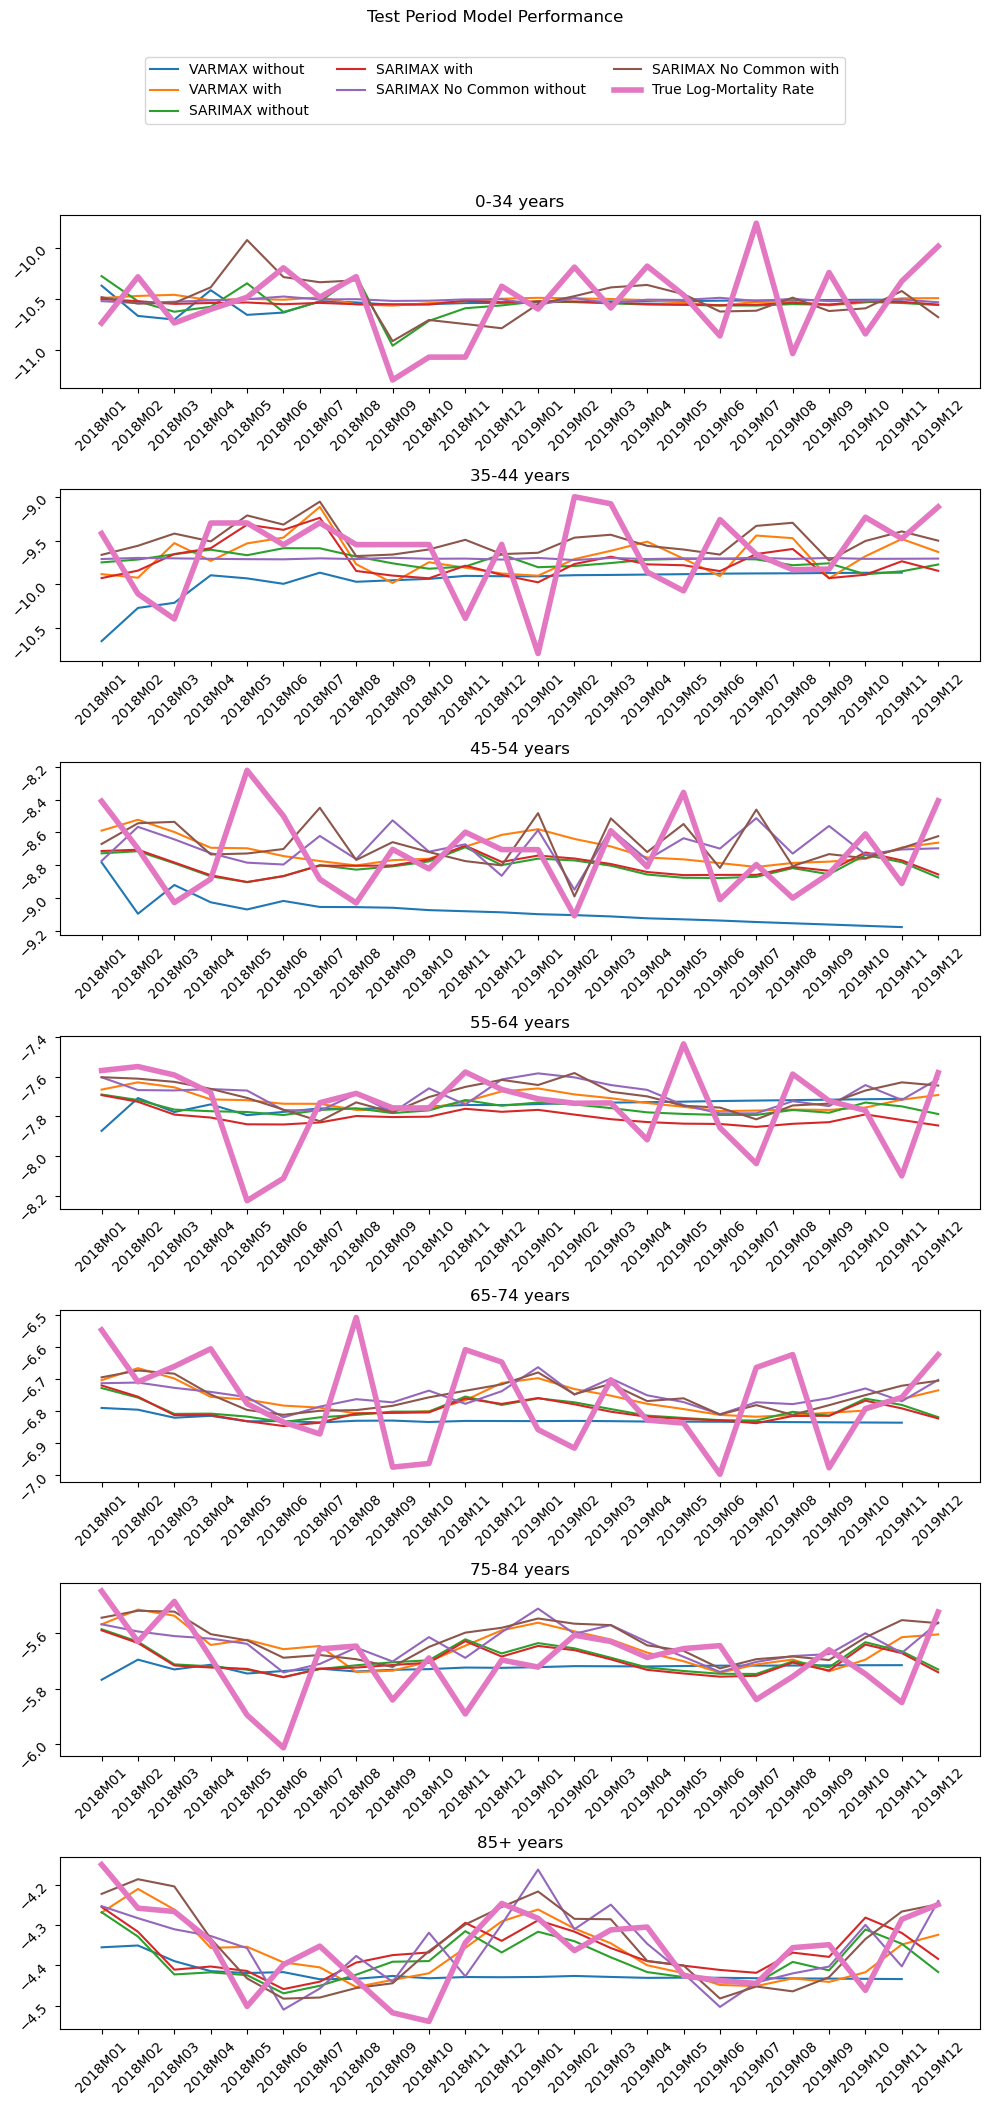

In [86]:
predictions_varwith = pd.DataFrame(predictions_varwith)
predictions_varwith.index = telemark_logmort_full.index
predictions_varwith.columns = telemark_logmort_full.columns

predictions_varout = pd.DataFrame(predictions_varout)
predictions_varout.index = telemark_logmort_full.index
predictions_varout.columns = telemark_logmort_full.columns


age_groups = all_nor_logmort.index
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(10, 20))

# Store lines and labels to create a single legend
lines = []
labels = []

for row in range(7):
    age = age_groups[row]
    axes[row].set_title(age)
    
    line1, = axes[row].plot(predictions_varout.iloc[row, 60:], label="VARMAX without")
    line2, = axes[row].plot(predictions_varwith.iloc[row, 60:], label="VARMAX with")
    line3, = axes[row].plot(regional_predictions_sarout.iloc[row, 60:], label="SARIMAX without")
    line4, = axes[row].plot(regional_predictions_sarwith.iloc[row, 60:], label="SARIMAX with")
    line5, = axes[row].plot(regional_predictions_nocommout.iloc[row, 60:], label="SARIMAX No Common without")
    line6, = axes[row].plot(regional_predictions_nocommwith.iloc[row, 60:], label="SARIMAX No Common with")
    line7, = axes[row].plot(telemark_logmort_full.iloc[row, 60:], label="True Log-Mortality Rate", linewidth=4)
    
    axes[row].tick_params(rotation=45)
    
    # Collect lines and labels for the legend
    if row == 0:
        lines.extend([line1, line2, line3, line4, line5, line6, line7])
        labels.extend([line.get_label() for line in lines])

# Create a single legend
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=3)
plt.suptitle("Test Period Model Performance", y=1.05)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# COVID Period Modelling

p_value k_t0 before re-estimation: 0.8225282943533825 

Regional k_t0 is white noise with LB p_value 0.8225282943533825 

p_value k_t1 before re-estimation: 0.3091916049319088 

Regional k_t1 is white noise with LB p_value 0.3091916049319088 

Proportion of k_t values which are positive[0.44047619 0.52380952] 

Proportion of b_x values which are positive[0.57142857 0.85714286] 

p_value k_t0 after re-estimation: 0.8771282938854179 

Regional k_t0 is white noise with LB p_value 0.8771282938854179 

p_value k_t1 after re-estimation: 0.33760764562959844 

Regional k_t1 is white noise with LB p_value 0.33760764562959844 

Model Error 11.77210217387406
Re_estimation error Each Age Group (MAPE): [0.18991976 0.07698886 1.64929406 1.12885702 0.88715585 1.02852011
 1.33142105]

 Prediction Error Each Age Group (MAPE)[2.4971746  2.61605493 1.58285646 1.50356651 1.14835233 1.41501723
 1.00908012]


<Figure size 640x480 with 0 Axes>

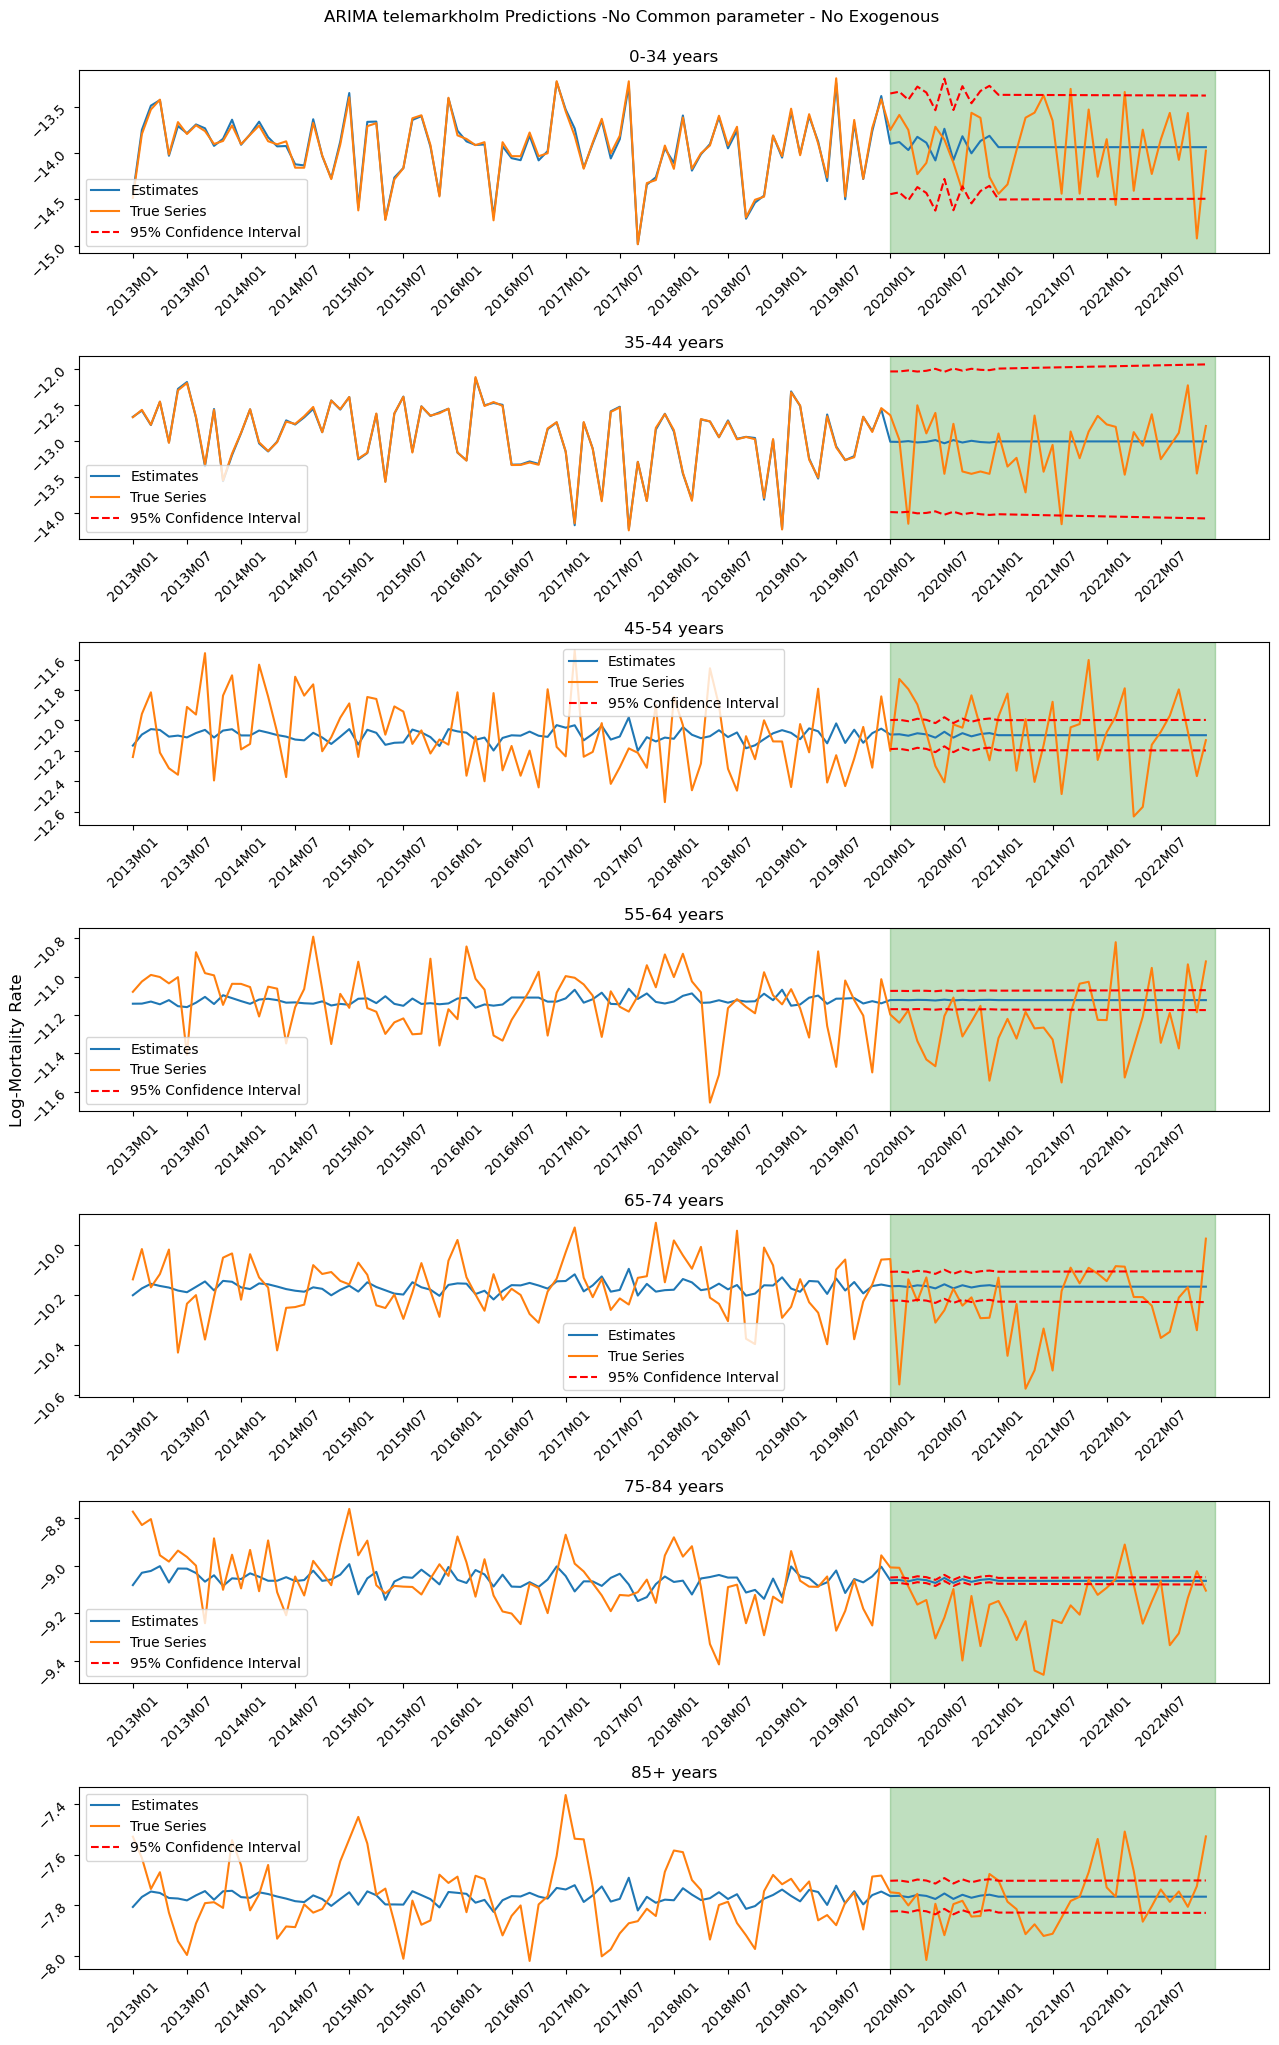

In [125]:
## Model No Common parameter - No Exogenous
a_xi,b_xs,k_ts,regional_re_est,k_t_models,k_t_preds,regional_predictions_nocommoutCOVID,regional_predictions_upconf,regional_predictions_lowconf,model_error,res,D = model_no_common(telemark_logmort_incCOVID,regional_terms = 2,prediction_period = 36,train_period = 84,region_deaths = telemark_death_COVID,region_pop = telemark_pop_COVID,re_est = False,smooth = False)

#exogenous_train = exog_train_telemark,exogenous_test = exog_test_telemark
regional_predictions_nocommoutCOVID = pd.DataFrame(regional_predictions_nocommoutCOVID)
regional_predictions_upconf = pd.DataFrame(regional_predictions_upconf)
regional_predictions_lowconf = pd.DataFrame(regional_predictions_lowconf)

regional_predictions_nocommoutCOVID.index = telemark_logmort_incCOVID.index
regional_predictions_nocommoutCOVID.columns = telemark_logmort_incCOVID.columns
regional_predictions_upconf.index = telemark_logmort_incCOVID.index
regional_predictions_upconf.columns = telemark_logmort_incCOVID.columns
regional_predictions_lowconf.index = telemark_logmort_incCOVID.index
regional_predictions_lowconf.columns = telemark_logmort_incCOVID.columns

print("Model Error " + str(model_error))
print("Re_estimation error Each Age Group (MAPE): "+str(MAPE(regional_predictions_nocommoutCOVID.iloc[:,:84],telemark_logmort_incCOVID.iloc[:,:84])))

#AIC_values = [K_t_models["model_0"].aic(),K_t_models["model_1"].aic(),k_t_models["model_0"].aic(),k_t_models["model_1"].aic()]
#print("\n Model AIC Values [K_t1,K_t2,k_t1,k_t2]: \n"+ str(AIC_values))

print("\n Prediction Error Each Age Group (MAPE)" +str(MAPE(regional_predictions_nocommoutCOVID.iloc[:,84:],telemark_logmort_incCOVID.iloc[:,84:])))
#print(k_t_models["model_0"].summary())

#telemark_pop_inCOVID = undo_person_days(pd.DataFrame(telemark_pop_inCOVID,columns = telemark_logmort_incCOVID.columns[-36:]))

exp_term = np.multiply(np.exp(a_xi+b_xs@np.diag(D)[:2,:2]@k_t_preds[:,84:]),telemark_pop_inCOVID) ### Add scaling of singular values
exp_term = np.round(exp_term,0)
pred_total_deaths = np.sum(exp_term,axis = 1)
actual_total_deaths = np.sum(telemark_death_inCOVID,axis = 1)

error_NoCom_woutCOVID = MAPE(regional_predictions_nocommoutCOVID.iloc[:,84:],telemark_logmort_incCOVID.iloc[:,84:])
prediction_plots(regional_predictions_nocommoutCOVID,regional_predictions_upconf,regional_predictions_lowconf,36,telemark_logmort_incCOVID,suptitle = "ARIMA telemarkholm Predictions -No Common parameter - No Exogenous ")



In [126]:
telemark_NoCom_NoExog_deaths_20 = pd.DataFrame(exp_term).iloc[:,:6].sum(axis = 1) #only first half of 2020
telemark_NoCom_NoExog_deaths_20_21 = epi_year(pd.DataFrame(exp_term))["year_0"].sum(axis = 1)
telemark_NoCom_NoExog_deaths_21_22 = epi_year(pd.DataFrame(exp_term))["year_1"].sum(axis = 1)
telemark_NoCom_NoExog_deaths_22 = epi_year(pd.DataFrame(exp_term))["year_2"].sum(axis = 1)

p_value k_t0 before re-estimation: 0.8225282943533825 

Regional k_t0 is white noise with LB p_value 0.8225282943533825 

p_value k_t1 before re-estimation: 0.3091916049319088 

Regional k_t1 is white noise with LB p_value 0.3091916049319088 

p_value k_t2 before re-estimation: 0.029431838576193747 

Proportion of k_t values which are positive[0.44047619 0.52380952 0.53571429] 

Proportion of b_x values which are positive[0.57142857 0.85714286 0.42857143] 

p_value k_t0 after re-estimation: 0.8771282938854179 

Regional k_t0 is white noise with LB p_value 0.8771282938854179 

p_value k_t1 after re-estimation: 0.33760764562959844 

Regional k_t1 is white noise with LB p_value 0.33760764562959844 

p_value k_t2 after re-estimation: 0.16283635921823147 

Regional k_t2 is white noise with LB p_value 0.16283635921823147 

Model Error 12.166754942103198
Re_estimation error Each Age Group (MAPE): [0.09701836 0.0547573  0.12828592 1.09308468 0.88219848 1.02892397
 1.32770876]

 Prediction Erro

<Figure size 640x480 with 0 Axes>

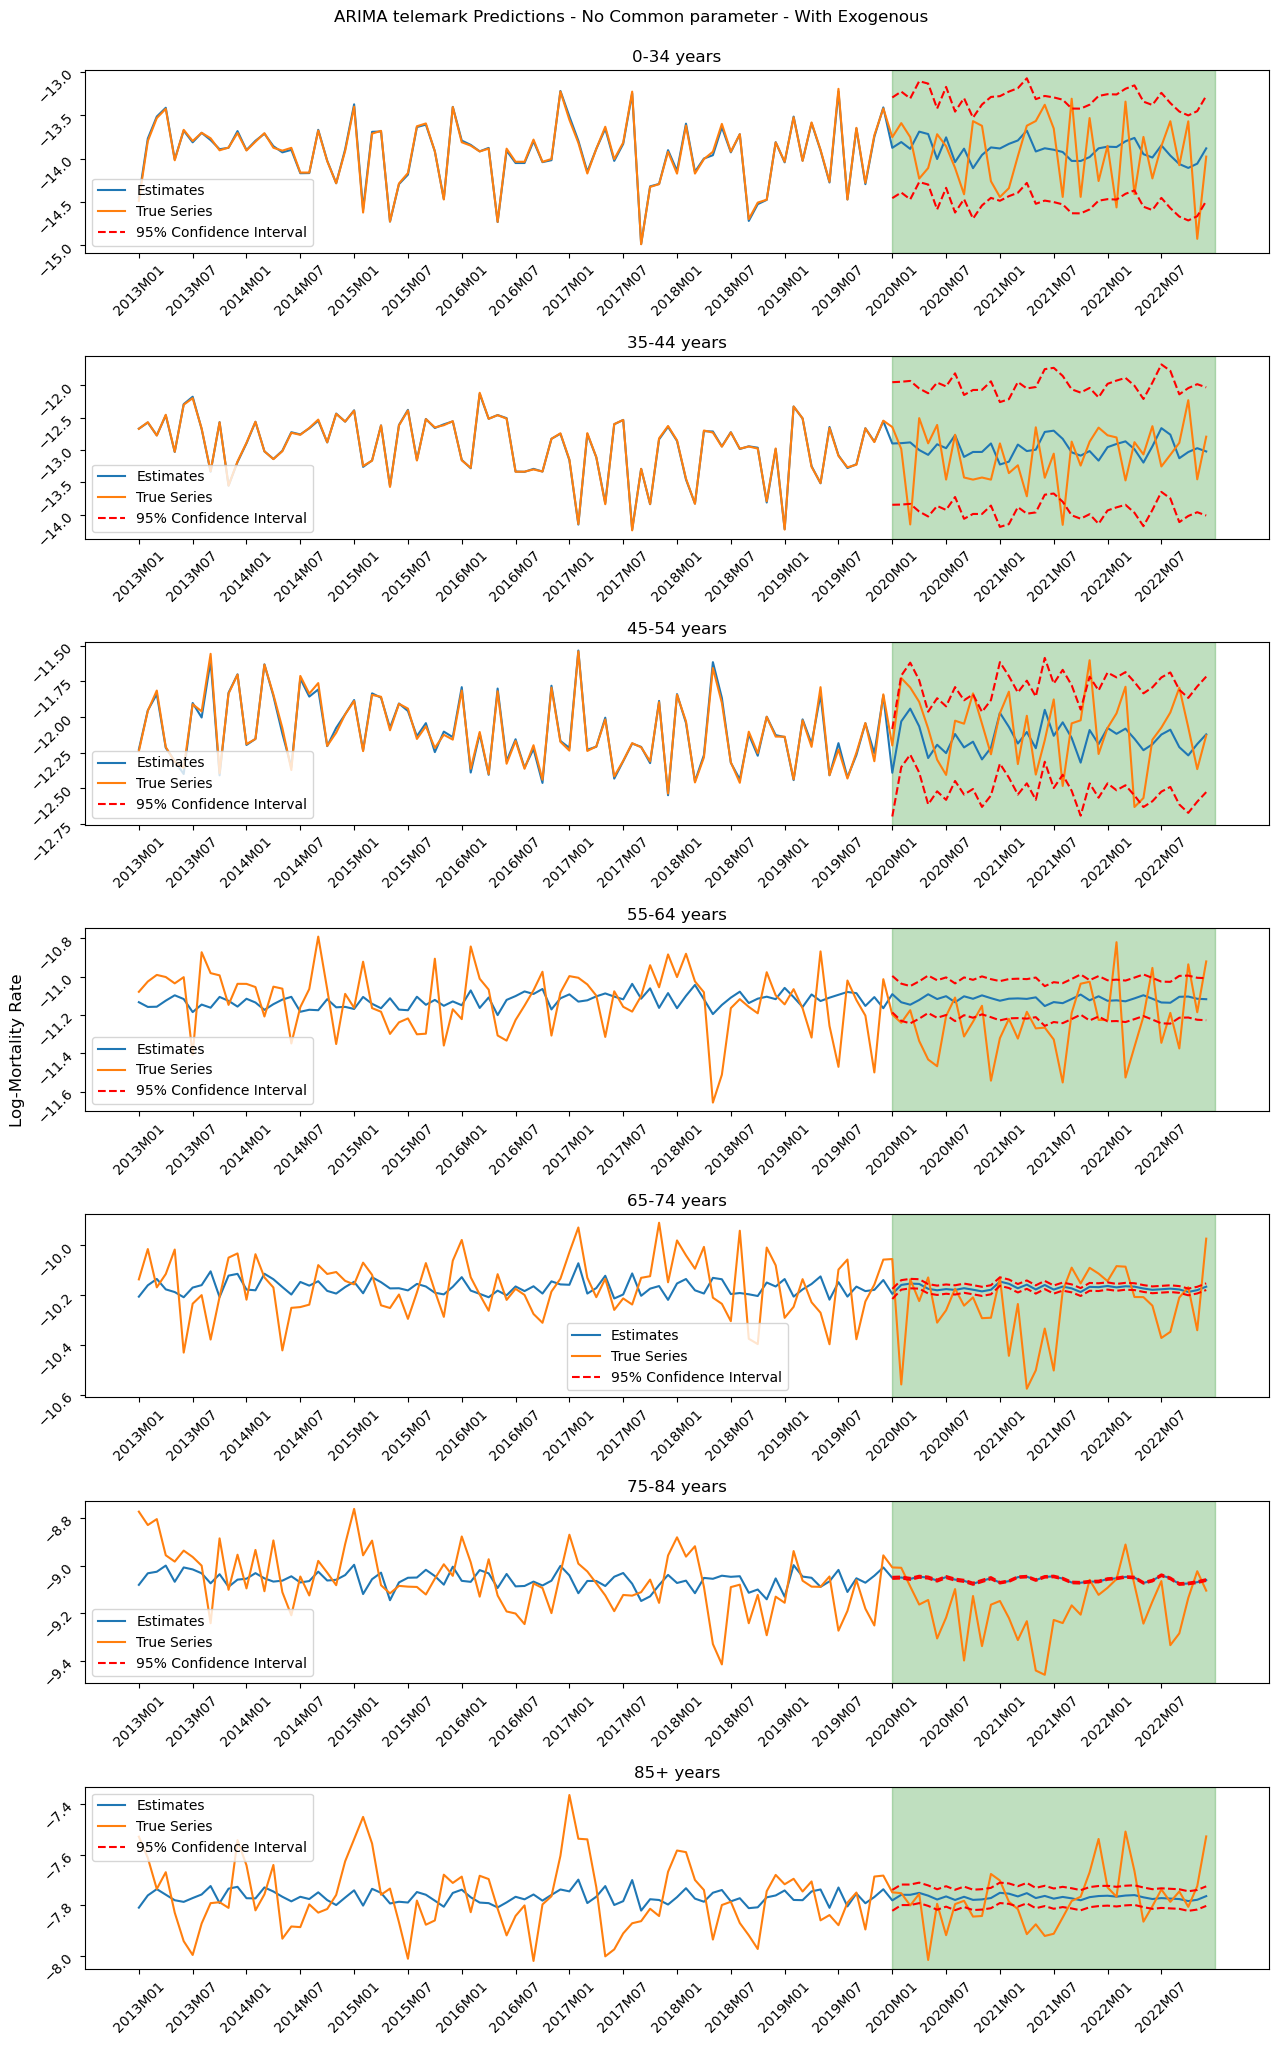

In [130]:
## Model No nocommon parameter - With Exogenous
## Model No nocommon parameter - With Exogenous
exog_train_telemark_COVID_2 = exog_train_telemark_COVID.iloc[:,:2]
exog_test_telemark_COVID_2 = exog_test_telemark_COVID.iloc[:,:2]
a_xi,b_xs,k_ts,regional_re_est,k_t_models,k_t_preds,regional_predictions_nocommwithCOVID,regional_predictions_upconf,regional_predictions_lowconf,model_error,res,D = model_no_common(telemark_logmort_incCOVID,regional_terms = 3,prediction_period = 36,train_period = 84,exogenous_train = exog_train_telemark_COVID,exogenous_test = exog_test_telemark_COVID,region_deaths = telemark_death_COVID,region_pop = telemark_pop_COVID,re_est = False,smooth = False)

#exogenous_train = exog_train_telemark,exogenous_test = exog_test_telemark
regional_predictions_nocommwithCOVID = pd.DataFrame(regional_predictions_nocommwithCOVID)
regional_predictions_upconf = pd.DataFrame(regional_predictions_upconf)
regional_predictions_lowconf = pd.DataFrame(regional_predictions_lowconf)

regional_predictions_nocommwithCOVID.index = telemark_logmort_incCOVID.index
regional_predictions_nocommwithCOVID.columns = telemark_logmort_incCOVID.columns
regional_predictions_upconf.index = telemark_logmort_incCOVID.index
regional_predictions_upconf.columns = telemark_logmort_incCOVID.columns
regional_predictions_lowconf.index = telemark_logmort_incCOVID.index
regional_predictions_lowconf.columns = telemark_logmort_incCOVID.columns

print("Model Error " + str(model_error))
print("Re_estimation error Each Age Group (MAPE): "+str(MAPE(regional_predictions_nocommwithCOVID.iloc[:,:84],telemark_logmort_incCOVID.iloc[:,:84])))

#AIC_values = [K_t_models["model_0"].aic(),K_t_models["model_1"].aic(),k_t_models["model_0"].aic(),k_t_models["model_1"].aic()]
#print("\n Model AIC Values [K_t1,K_t2,k_t1,k_t2]: \n"+ str(AIC_values))

print("\n Prediction Error Each Age Group (MAPE)" +str(MAPE(regional_predictions_nocommwithCOVID.iloc[:,84:],telemark_logmort_incCOVID.iloc[:,84:])))
#print(k_t_models["model_0"].summary())

#telemark_pop_inCOVID = undo_person_days(pd.DataFrame(telemark_pop_inCOVID,columns = telemark_logmort_incCOVID.columns[-36:]))

exp_term = np.multiply(np.exp(a_xi+ b_xs@np.diag(D)[:3,:3]@k_t_preds[:,84:]),telemark_pop_inCOVID) ### Add scaling of singular values
exp_term = np.round(exp_term,0)
pred_total_deaths = np.sum(exp_term,axis = 1)
actual_total_deaths = np.sum(telemark_death_inCOVID,axis = 1)



error_NoCom_withCOVID = MAPE(regional_predictions_nocommwithCOVID.iloc[:,84:],telemark_logmort_incCOVID.iloc[:,84:])
prediction_plots(regional_predictions_nocommwithCOVID,regional_predictions_upconf,regional_predictions_lowconf,36,telemark_logmort_incCOVID,suptitle = "ARIMA telemark Predictions - No Common parameter - With Exogenous ")



In [131]:
telemark_NoCom_WithExog_deaths_20 = pd.DataFrame(exp_term).iloc[:,:6].sum(axis = 1) #only first half of 2020
telemark_NoCom_WithExog_deaths_20_21 = epi_year(pd.DataFrame(exp_term))["year_0"].sum(axis = 1)
telemark_NoCom_WithExog_deaths_21_22 = epi_year(pd.DataFrame(exp_term))["year_1"].sum(axis = 1)
telemark_NoCom_WithExog_deaths_22 = epi_year(pd.DataFrame(exp_term))["year_2"].sum(axis = 1)

p_value k_t0 before re-estimation: 1.0709706377798425e-07 

p_value k_t0 after re-estimation: 1.0709706377798425e-07 

Model Error 8.450485756844419
Re_estimation error Each Age Group (MAPE): [2.46473435 2.78089207 2.22943863 1.41516483 1.26226168 1.37480265
 1.89917197]

 Prediction Error Each Age Group (MAPE)[3.29176904 3.52616996 2.64431789 1.70395133 1.74002676 1.76670329
 2.92312495]

Predicted number of deaths for COVID period [ 288.  218.  581. 1425. 3251. 5511. 7308.]
Actual number of deaths for COVID period [ 313  224  646 1380 3202 5392 7869]
Actual deaths over predicted deaths [1.08680556 1.02752294 1.11187608 0.96842105 0.98492771 0.97840682
 1.07676519]
Total Excess Mortality (Actual - Predicted): -444.0
Excess Mortality Ratio (Actual/Predicted): 0.9766635130873541


<Figure size 640x480 with 0 Axes>

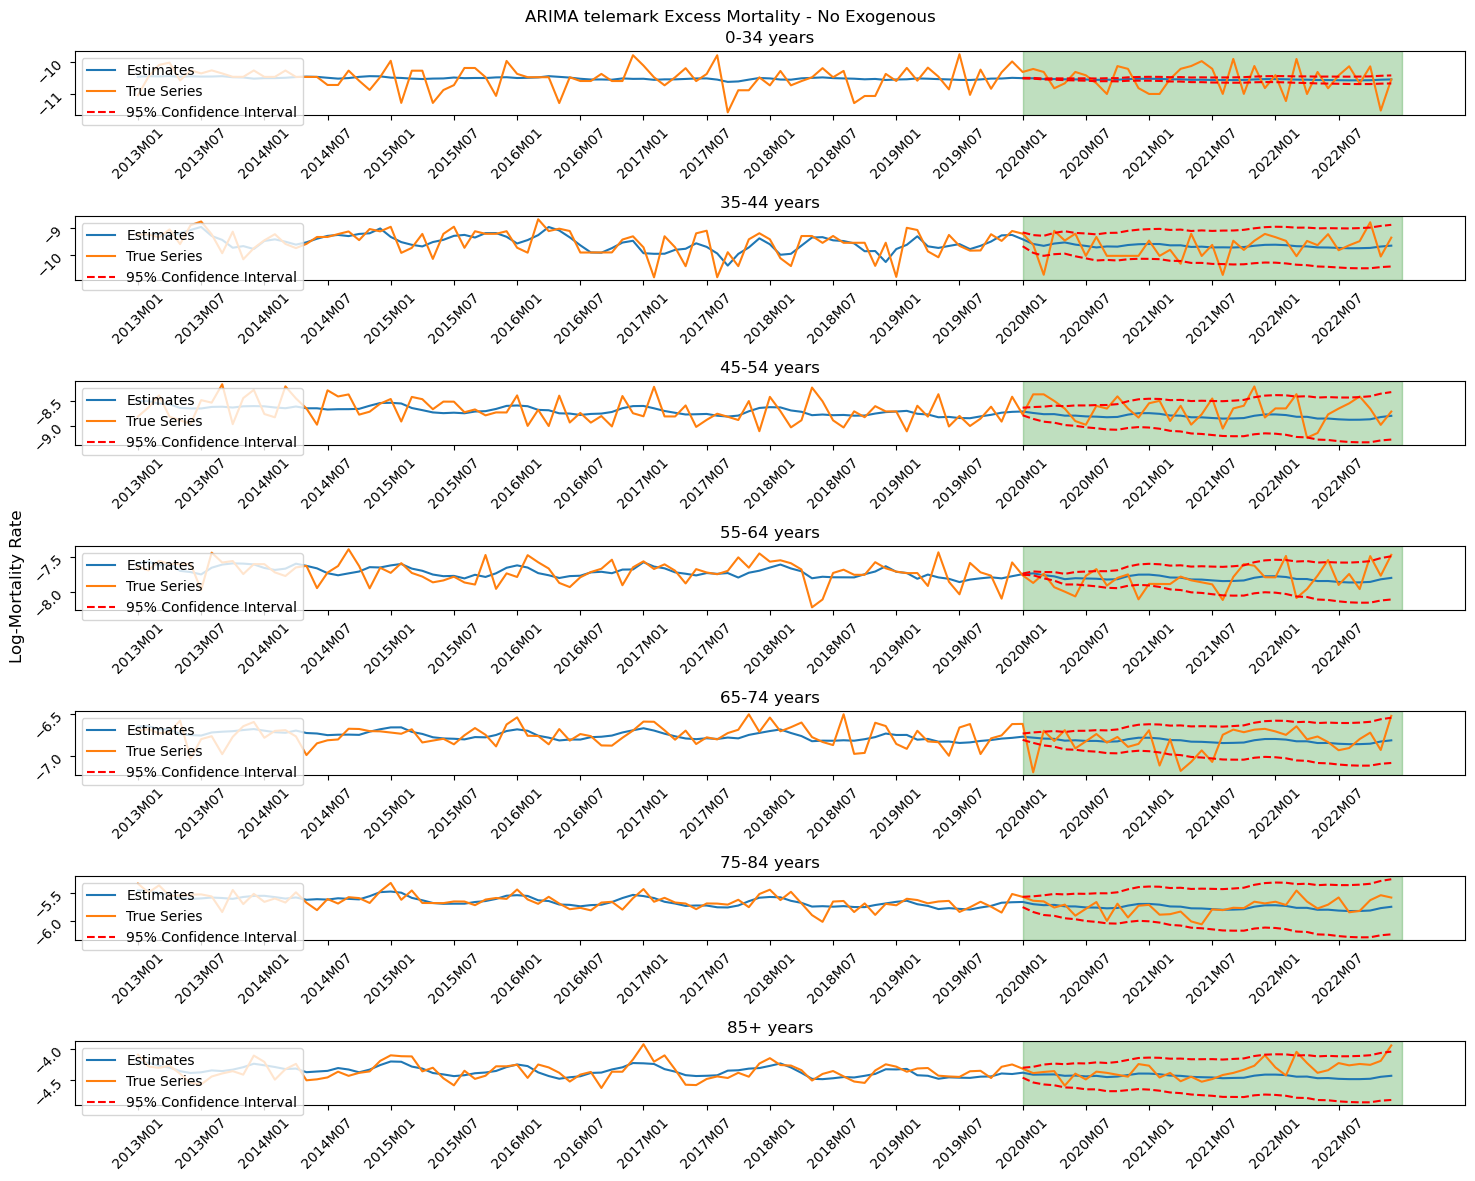

In [91]:
### Without Exogenous 2 common 4 regional 
### Without Exogenous
a_xi,B_xs,K_ts,b_xs,k_ts,country_re_est,regional_re_est,K_t_models,k_t_models_sarout,K_t_preds,k_t_preds,regional_predictions_saroutCOVID,regional_predictions_upconf,regional_predictions_lowconf,model_error,res,_,_ = full_model(all_nor_logmort_incCOVID,telemark_logmort_incCOVID, common_terms = 2,regional_terms = 1,prediction_period = 36,train_period = 84,country_deaths = nor_death_COVID, country_pop = nor_pop_COVID,region_deaths = telemark_death_COVID,region_pop = telemark_pop_COVID,re_est = False,smooth = True)  


regional_predictions_saroutCOVID = pd.DataFrame(regional_predictions_saroutCOVID)
regional_predictions_upconf = pd.DataFrame(regional_predictions_upconf)
regional_predictions_lowconf = pd.DataFrame(regional_predictions_lowconf)

regional_predictions_saroutCOVID.index = telemark_logmort_incCOVID.index
regional_predictions_saroutCOVID.columns = telemark_logmort_incCOVID.columns
regional_predictions_upconf.index = telemark_logmort_incCOVID.index
regional_predictions_upconf.columns = telemark_logmort_incCOVID.columns
regional_predictions_lowconf.index = telemark_logmort_incCOVID.index
regional_predictions_lowconf.columns = telemark_logmort_incCOVID.columns

print("Model Error " + str(model_error))
print("Re_estimation error Each Age Group (MAPE): "+str(MAPE(regional_predictions_saroutCOVID.iloc[:,:84],telemark_logmort_incCOVID.iloc[:,:84])))

#AIC_values = [K_t_models["model_0"].aic(),K_t_models["model_1"].aic(),k_t_models["model_0"].aic(),k_t_models["model_1"].aic()]
#print("\n Model AIC Values [K_t1,K_t2,k_t1,k_t2]: \n"+ str(AIC_values))

print("\n Prediction Error Each Age Group (MAPE)" +str(MAPE(regional_predictions_saroutCOVID.iloc[:,84:],telemark_logmort_incCOVID.iloc[:,84:])))

#telemark_pop_inCOVID = undo_person_days(pd.DataFrame(telemark_pop_inCOVID,columns = telemark_logmort_incCOVID.columns[-36:]))

exp_term = np.multiply(np.exp(a_xi+B_xs@K_t_preds[:,84:] + b_xs@k_t_preds[:,84:]),telemark_pop_inCOVID)
exp_term = np.round(exp_term,0)
pred_total_deaths = np.sum(exp_term,axis = 1)
actual_total_deaths = np.sum(telemark_death_inCOVID,axis = 1)
print("\nPredicted number of deaths for COVID period " + str(pred_total_deaths))
print("Actual number of deaths for COVID period " + str(actual_total_deaths))
print("Actual deaths over predicted deaths " +str(actual_total_deaths/pred_total_deaths))
print("Total Excess Mortality (Actual - Predicted): " + str(np.sum(pred_total_deaths) - np.sum(actual_total_deaths)))
print("Excess Mortality Ratio (Actual/Predicted): " + str(np.sum(pred_total_deaths)/np.sum(actual_total_deaths)))


regional_predictions_saroutCOVID
error_SARIMAX_woutCOVID = MAPE(regional_predictions_saroutCOVID.iloc[:,84:],telemark_logmort_incCOVID.iloc[:,84:])
prediction_plots(regional_predictions_saroutCOVID,regional_predictions_upconf,regional_predictions_lowconf,36,telemark_logmort_incCOVID,suptitle = "ARIMA telemark Excess Mortality - No Exogenous")


In [16]:
print(str(K_t_models["model_0"].get_params()["order"]) + str(K_t_models["model_0"].get_params()["seasonal_order"]))
print(str(K_t_models["model_1"].get_params()["order"]) + str(K_t_models["model_1"].get_params()["seasonal_order"]))
print("-")
print(str(k_t_models_sarout["model_0"].get_params()["order"]) + str(k_t_models_sarout["model_0"].get_params()["seasonal_order"]))
print(str(k_t_models_sarout["model_1"].get_params()["order"]) + str(k_t_models_sarout["model_1"].get_params()["seasonal_order"]))
print(str(k_t_models_sarout["model_2"].get_params()["order"]) + str(k_t_models_sarout["model_2"].get_params()["seasonal_order"]))
print(str(k_t_models_sarout["model_3"].get_params()["order"]) + str(k_t_models_sarout["model_3"].get_params()["seasonal_order"]))



(1, 1, 0)(1, 0, 2, 12)
(8, 0, 0)(1, 0, 0, 12)
-
(4, 0, 0)(0, 0, 0, 12)


KeyError: 'model_1'

p_value k_t0 before re-estimation: 1.1853940042088376e-07 

p_value k_t0 after re-estimation: 1.1853940042088376e-07 

Model Error 8.045246533367818
Re_estimation error Each Age Group (MAPE): [2.50440132 2.78417601 2.24145059 1.41902144 1.2455505  1.38364628
 1.50774609]

 Prediction Error Each Age Group (MAPE)[3.3776902  3.53639062 2.81344148 1.69352145 1.72196582 1.74579209
 2.51955346]

Predicted number of deaths for COVID period [ 276.  224.  551. 1388. 3269. 5582. 7674.]
Actual number of deaths for COVID period [ 313  224  646 1380 3202 5392 7869]
Actual deaths over predicted deaths [1.13405797 1.         1.17241379 0.99423631 0.97950444 0.96596202
 1.02541048]
Total Excess Mortality (Actual - Predicted): -62.0
Excess Mortality Ratio (Actual/Predicted): 0.996741301377063


<Figure size 640x480 with 0 Axes>

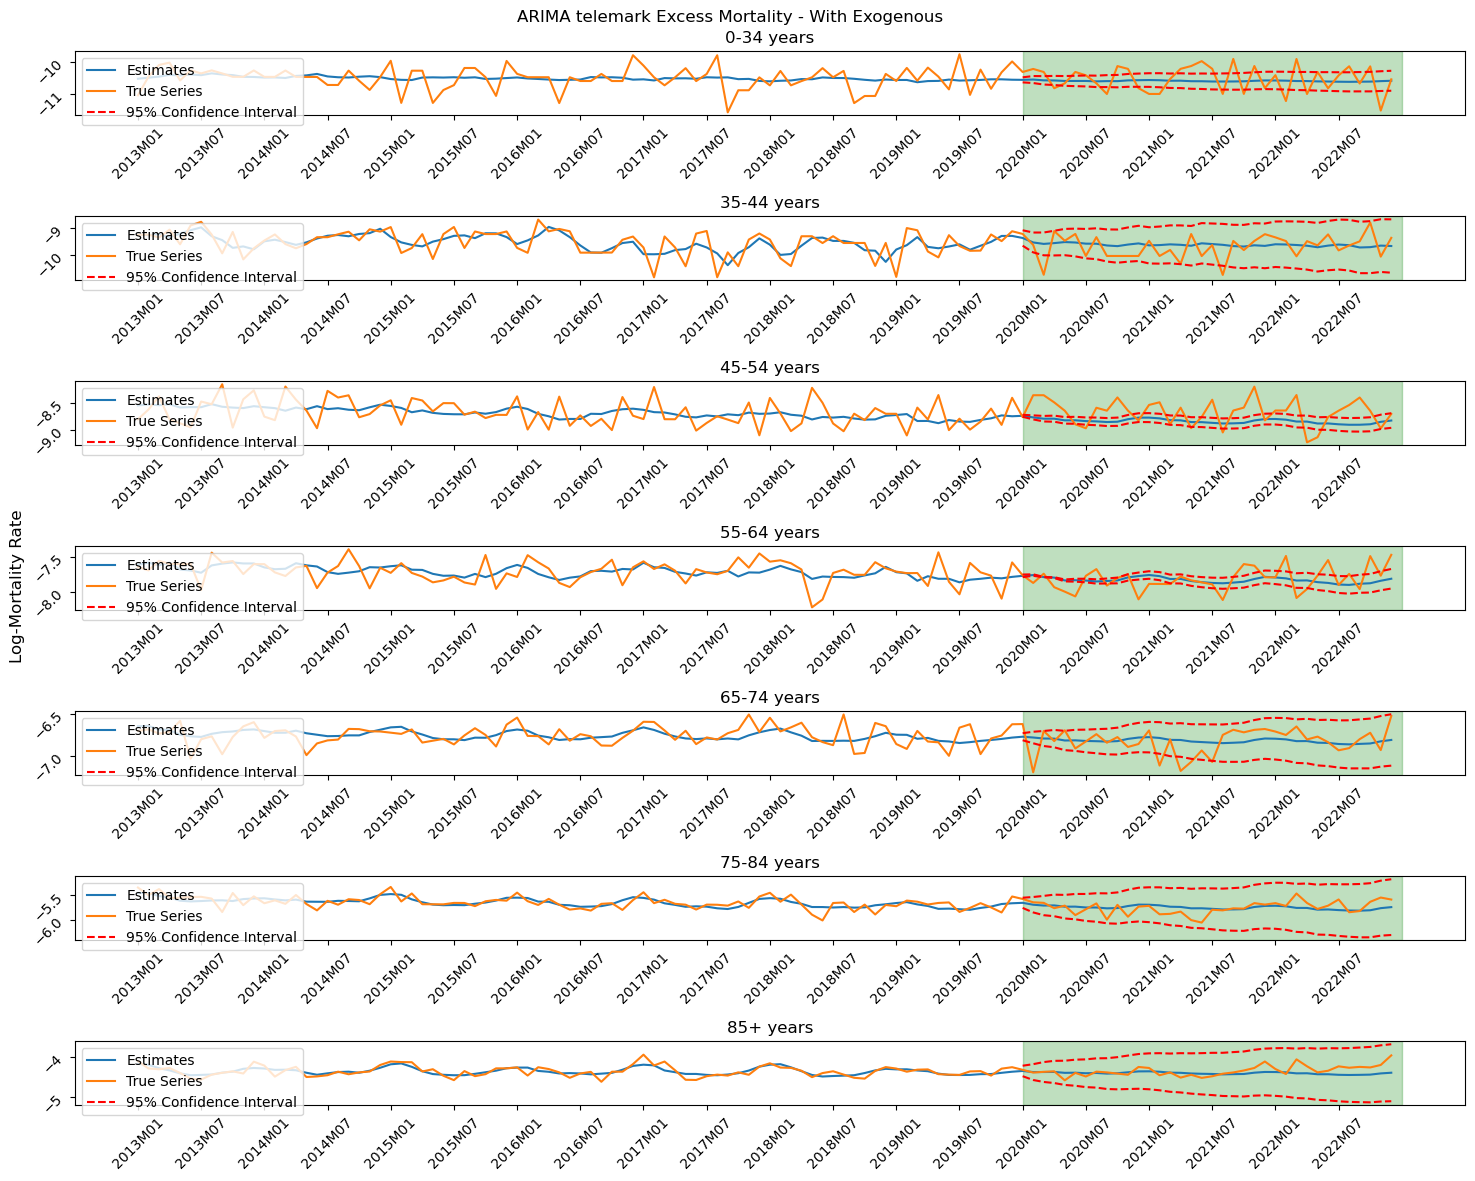

In [92]:
### With Exogenous
a_xi,B_xs,K_ts,b_xs,k_ts,country_re_est,regional_re_est,K_t_models,k_t_models_sarw,K_t_preds,k_t_preds,regional_predictions_sarwithCOVID,regional_predictions_upconf,regional_predictions_lowconf,model_error,res,_,_ = full_model(all_nor_logmort_incCOVID,telemark_logmort_incCOVID, common_terms = 3,regional_terms = 1,prediction_period = 36,train_period = 84,exogenous_train = exog_train_telemark_COVID,exogenous_test = exog_test_telemark_COVID,country_deaths = nor_death_COVID, country_pop = nor_pop_COVID,region_deaths = telemark_death_COVID,region_pop = telemark_pop_COVID,re_est = False,smooth = True)  


regional_predictions_sarwithCOVID = pd.DataFrame(regional_predictions_sarwithCOVID)
regional_predictions_upconf = pd.DataFrame(regional_predictions_upconf)
regional_predictions_lowconf = pd.DataFrame(regional_predictions_lowconf)

regional_predictions_sarwithCOVID.index = telemark_logmort_incCOVID.index
regional_predictions_sarwithCOVID.columns = telemark_logmort_incCOVID.columns
regional_predictions_upconf.index = telemark_logmort_incCOVID.index
regional_predictions_upconf.columns = telemark_logmort_incCOVID.columns
regional_predictions_lowconf.index = telemark_logmort_incCOVID.index
regional_predictions_lowconf.columns = telemark_logmort_incCOVID.columns

print("Model Error " + str(model_error))
print("Re_estimation error Each Age Group (MAPE): "+str(MAPE(regional_predictions_sarwithCOVID.iloc[:,:84],telemark_logmort_incCOVID.iloc[:,:84])))

#AIC_values = [K_t_models["model_0"].aic(),K_t_models["model_1"].aic(),k_t_models["model_0"].aic(),k_t_models["model_1"].aic()]
#print("\n Model AIC Values [K_t1,K_t2,k_t1,k_t2]: \n"+ str(AIC_values))

print("\n Prediction Error Each Age Group (MAPE)" +str(MAPE(regional_predictions_sarwithCOVID.iloc[:,84:],telemark_logmort_incCOVID.iloc[:,84:])))

#telemark_pop_inCOVID = undo_person_days(pd.DataFrame(telemark_pop_inCOVID,columns = telemark_logmort_incCOVID.columns[-36:]))

exp_term = np.multiply(np.exp(a_xi+B_xs@K_t_preds[:,84:] + b_xs@k_t_preds[:,84:]),telemark_pop_inCOVID)
exp_term = np.round(exp_term,0)
pred_total_deaths = np.sum(exp_term,axis = 1)
actual_total_deaths = np.sum(telemark_death_inCOVID,axis = 1)
print("\nPredicted number of deaths for COVID period " + str(pred_total_deaths))
print("Actual number of deaths for COVID period " + str(actual_total_deaths))
print("Actual deaths over predicted deaths " +str(actual_total_deaths/pred_total_deaths))
print("Total Excess Mortality (Actual - Predicted): " + str(np.sum(pred_total_deaths) - np.sum(actual_total_deaths)))
print("Excess Mortality Ratio (Actual/Predicted): " + str(np.sum(pred_total_deaths)/np.sum(actual_total_deaths)))


error_SARIMAX_withCOVID = MAPE(regional_predictions_sarwithCOVID.iloc[:,84:],telemark_logmort_incCOVID.iloc[:,84:])
prediction_plots(regional_predictions_sarwithCOVID,regional_predictions_upconf,regional_predictions_lowconf,36,telemark_logmort_incCOVID,suptitle = "ARIMA telemark Excess Mortality - With Exogenous")



In [44]:
print(str(K_t_models["model_0"].get_params()["order"]) + str(K_t_models["model_0"].get_params()["seasonal_order"]))
print("-")
print(str(k_t_models_sarw["model_0"].get_params()["order"]) + str(k_t_models_sarw["model_0"].get_params()["seasonal_order"]))
print(str(k_t_models_sarw["model_1"].get_params()["order"]) + str(k_t_models_sarw["model_1"].get_params()["seasonal_order"]))
print(str(k_t_models_sarw["model_2"].get_params()["order"]) + str(k_t_models_sarw["model_2"].get_params()["seasonal_order"]))



(1, 0, 0)(1, 0, 1, 12)
-
(0, 1, 1)(0, 0, 1, 12)
(0, 1, 1)(0, 0, 0, 12)
(0, 1, 1)(1, 0, 0, 12)


test_errors[3.69484682 7.01074536 4.03470241 2.49485182 2.68873348 3.91126664
 5.78704716]

Predicted number of deaths for COVID period [nan nan nan nan nan nan nan]
Actual number of deaths for COVID period [ 313  224  646 1380 3202 5392 7869]
Actual deaths over predicted deaths [nan nan nan nan nan nan nan]
Total Excess Mortality (Actual - Predicted): nan
Excess Mortality Ratio (Actual/Predicted): nan


<Figure size 640x480 with 0 Axes>

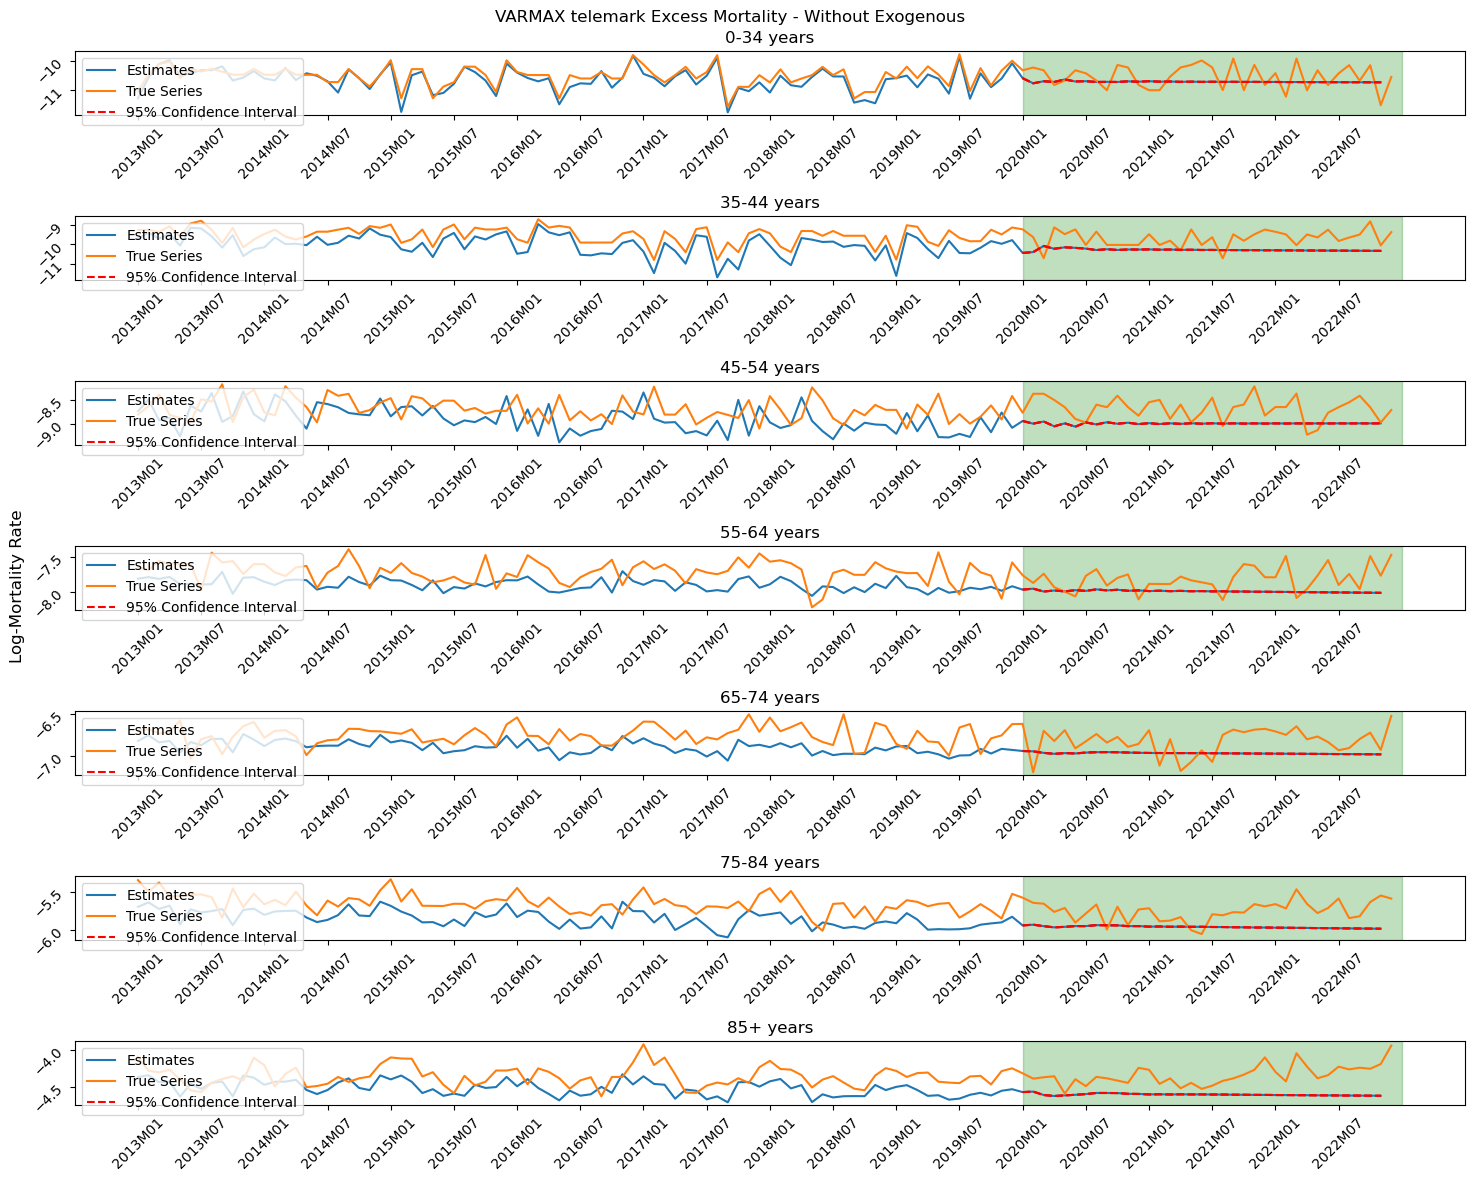

In [93]:
all_k_t, K_ts,k_ts,B_xs,b_xs,a_xi,all_k_preds,predictions_VAR_woutCOVID,predictions_lowconf,predictions_upconf,model_VAR_woutCOVID,aic,error_VAR_woutCOVID,_,_ = VARMAX_model(all_nor_logmort_incCOVID,telemark_logmort_incCOVID, common_terms = 3,regional_terms = 3,prediction_period = 36,train_period = 84,AR= 3,MA = 2, country_deaths = nor_death_COVID,country_pop = nor_pop_COVID,region_deaths = telemark_death_COVID,region_pop = telemark_pop_COVID,re_est = False)


print("test_errors" + str(error_VAR_woutCOVID))

K_t_preds = np.array(all_k_preds.iloc[84:,:3].fillna(method="ffill")).transpose() # change column number to match number of common terms
k_t_preds = np.array(all_k_preds.iloc[84:,3:]).transpose()

#telemark_pop_inCOVID = undo_person_days(pd.DataFrame(telemark_pop_inCOVID,columns = telemark_logmort_incCOVID.columns[-36:]))

exp_term = np.multiply(np.exp(a_xi+B_xs@K_t_preds + b_xs@k_t_preds),telemark_pop_inCOVID)
exp_term = np.round(exp_term,0)
pred_total_deaths = np.sum(exp_term,axis = 1)
actual_total_deaths = np.sum(telemark_death_inCOVID,axis = 1)
print("\nPredicted number of deaths for COVID period " + str(pred_total_deaths))
print("Actual number of deaths for COVID period " + str(actual_total_deaths))
print("Actual deaths over predicted deaths " +str(actual_total_deaths/pred_total_deaths))
print("Total Excess Mortality (Actual - Predicted): " + str(np.sum(pred_total_deaths) - np.sum(actual_total_deaths)))
print("Excess Mortality Ratio (Actual/Predicted): " + str(np.sum(pred_total_deaths)/np.sum(actual_total_deaths)))


prediction_plots(predictions_VAR_woutCOVID,predictions_VAR_woutCOVID,predictions_VAR_woutCOVID,36,telemark_logmort_incCOVID,suptitle = "VARMAX telemark Excess Mortality - Without Exogenous")



test_errors[1.99679022 3.71867376 5.05210026 2.98926887 2.42202021 4.37822169
 6.22966444]

Predicted number of deaths for COVID period [ 283.  167.  467. 1200. 2905. 4672. 6475.]
Actual number of deaths for COVID period [ 313  224  646 1380 3202 5392 7869]
Actual deaths over predicted deaths [1.10600707 1.34131737 1.38329764 1.15       1.10223752 1.15410959
 1.21528958]


<Figure size 640x480 with 0 Axes>

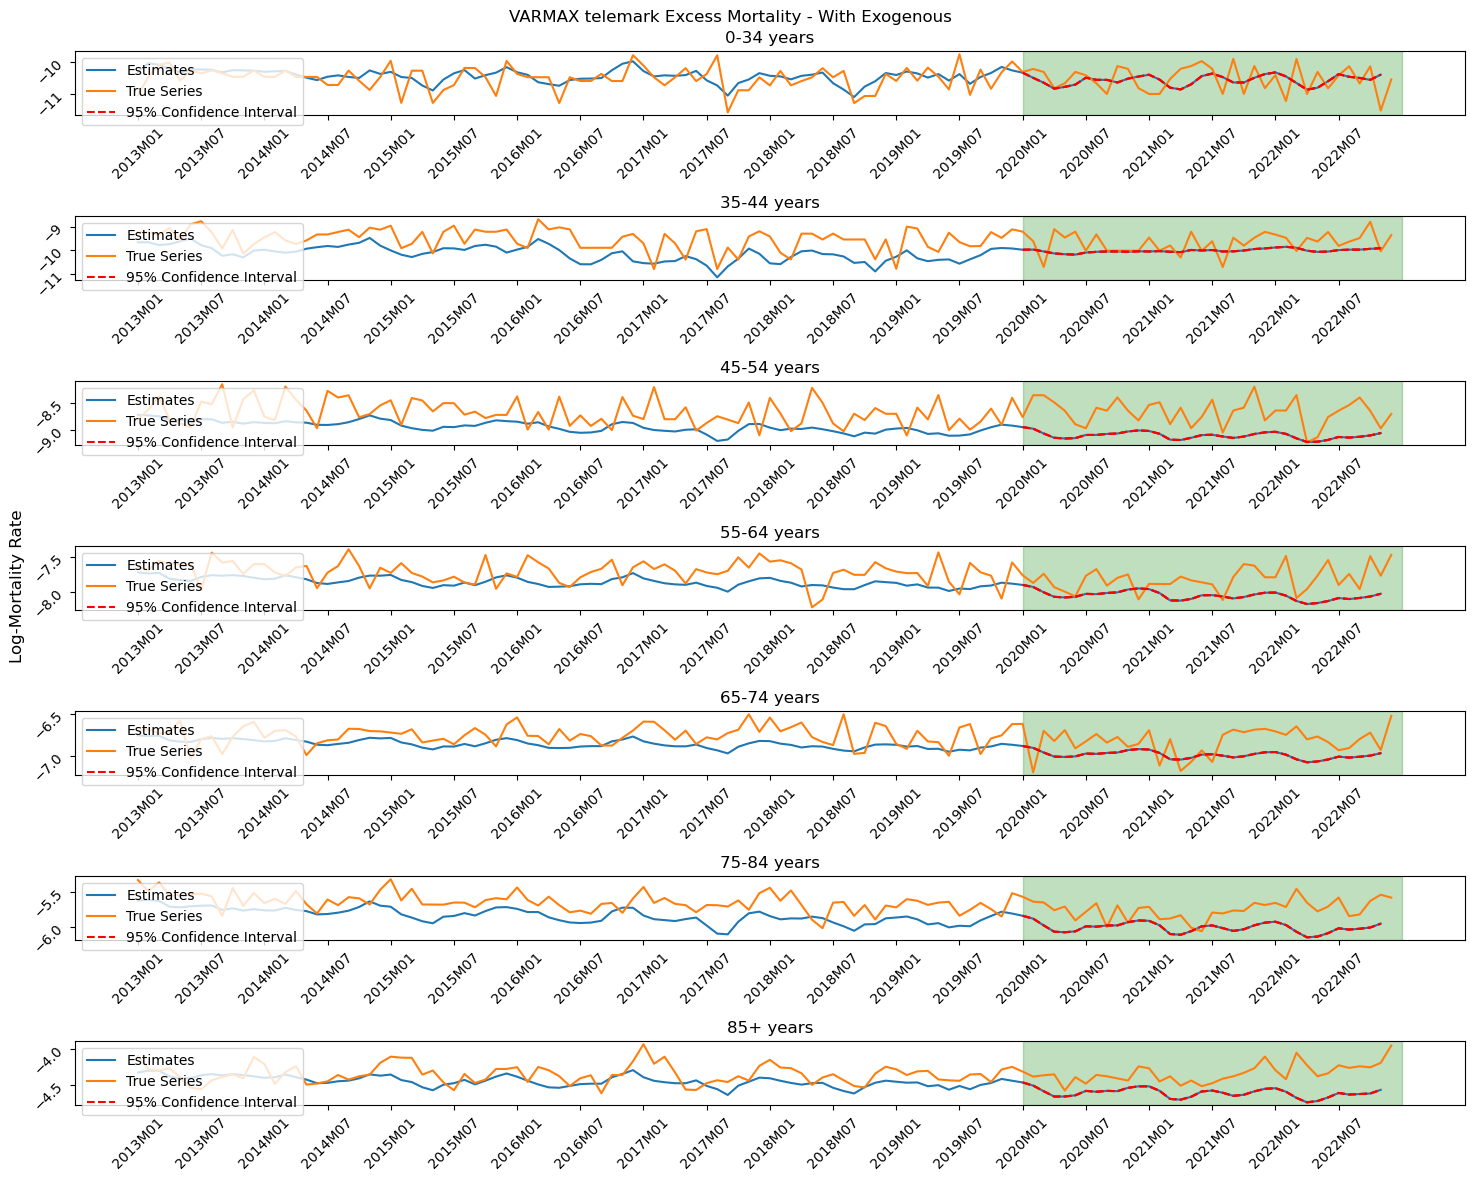

In [94]:
#exog_train_telemark_COVID = lag_exogenous(exog_train_telemark_COVID,numlags = 4)
#exog_test_telemark_COVID = lag_exogenous(exog_test_telemark_COVID,numlags = 4)
all_k_t, K_ts,k_ts,B_xs,b_xs,a_xi,all_k_preds,predictions_VAR_withCOVID,predictions_lowconf,predictions_upconf,model_VAR_withCOVID,aic,error_VAR_withCOVID,_,_ = VARMAX_model(all_nor_logmort_incCOVID,telemark_logmort_incCOVID, common_terms = 1,regional_terms = 2,prediction_period = 36,train_period = 84,AR= 4,MA = 4,exogenous_train = exog_train_telemark_COVID,exogenous_test = exog_test_telemark_COVID,country_deaths = nor_death_COVID, country_pop = nor_pop_COVID,region_deaths = telemark_death_COVID,region_pop = telemark_pop_COVID,re_est = False,smooth = True)


print("test_errors" + str(error_VAR_withCOVID))

K_t_preds = np.array(all_k_preds.iloc[84:,:1].fillna(method="ffill")).transpose()
k_t_preds = np.array(all_k_preds.iloc[84:,1:].fillna(method = "ffill")).transpose()

#telemark_pop_inCOVID = undo_person_days(pd.DataFrame(telemark_pop_inCOVID,columns = telemark_logmort_incCOVID.columns[-36:]))

exp_term = np.multiply(np.exp(a_xi+B_xs@K_t_preds + b_xs@k_t_preds),telemark_pop_inCOVID)
exp_term = np.round(exp_term,0)
pred_total_deaths = np.sum(exp_term,axis = 1)
actual_total_deaths = np.sum(telemark_death_inCOVID,axis = 1)
print("\nPredicted number of deaths for COVID period " + str(pred_total_deaths))
print("Actual number of deaths for COVID period " + str(actual_total_deaths))
print("Actual deaths over predicted deaths " +str(actual_total_deaths/pred_total_deaths))

prediction_plots(predictions_VAR_withCOVID,predictions_VAR_withCOVID,predictions_VAR_withCOVID,36,telemark_logmort_incCOVID,suptitle = "VARMAX telemark Excess Mortality - With Exogenous")


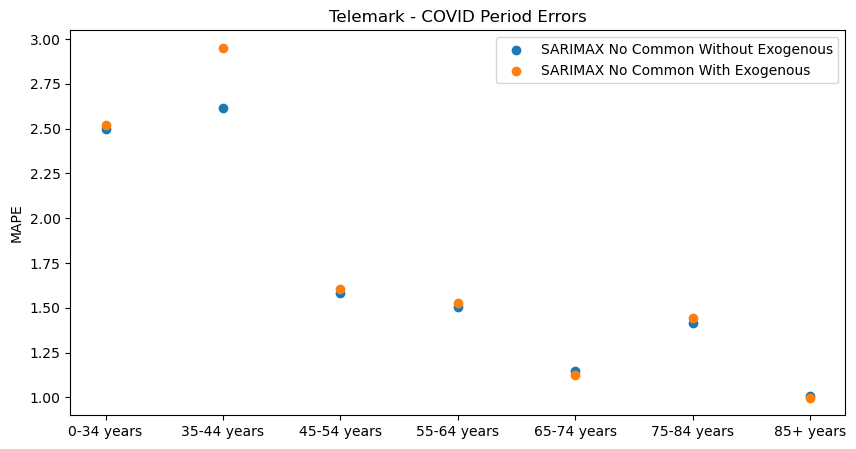

In [132]:
test_errors = np.vstack((error_SARIMAX_woutCOVID,error_SARIMAX_withCOVID,error_VAR_woutCOVID,error_VAR_withCOVID,error_NoCom_woutCOVID,error_NoCom_withCOVID))
telemark = test_errors

age_groups = telemark_logmort.index
plt.figure(figsize = (10,5))
# plt.scatter(age_groups,telemark[0,:],label = "SARIMAX Without Exogenous")
# plt.scatter(age_groups,telemark[1,:],label = "SARIMAX With Exogenous")
# plt.scatter(age_groups,telemark[2,:],label = "VARMAX Without Exogenous")
# plt.scatter(age_groups,telemark[3,:],label = "VARMAX With Exogenous")
plt.scatter(age_groups,telemark[4,:],label = "SARIMAX No Common Without Exogenous")
plt.scatter(age_groups,telemark[5,:],label = "SARIMAX No Common With Exogenous")
plt.legend();
plt.ylabel("MAPE")
plt.title("Telemark - COVID Period Errors");

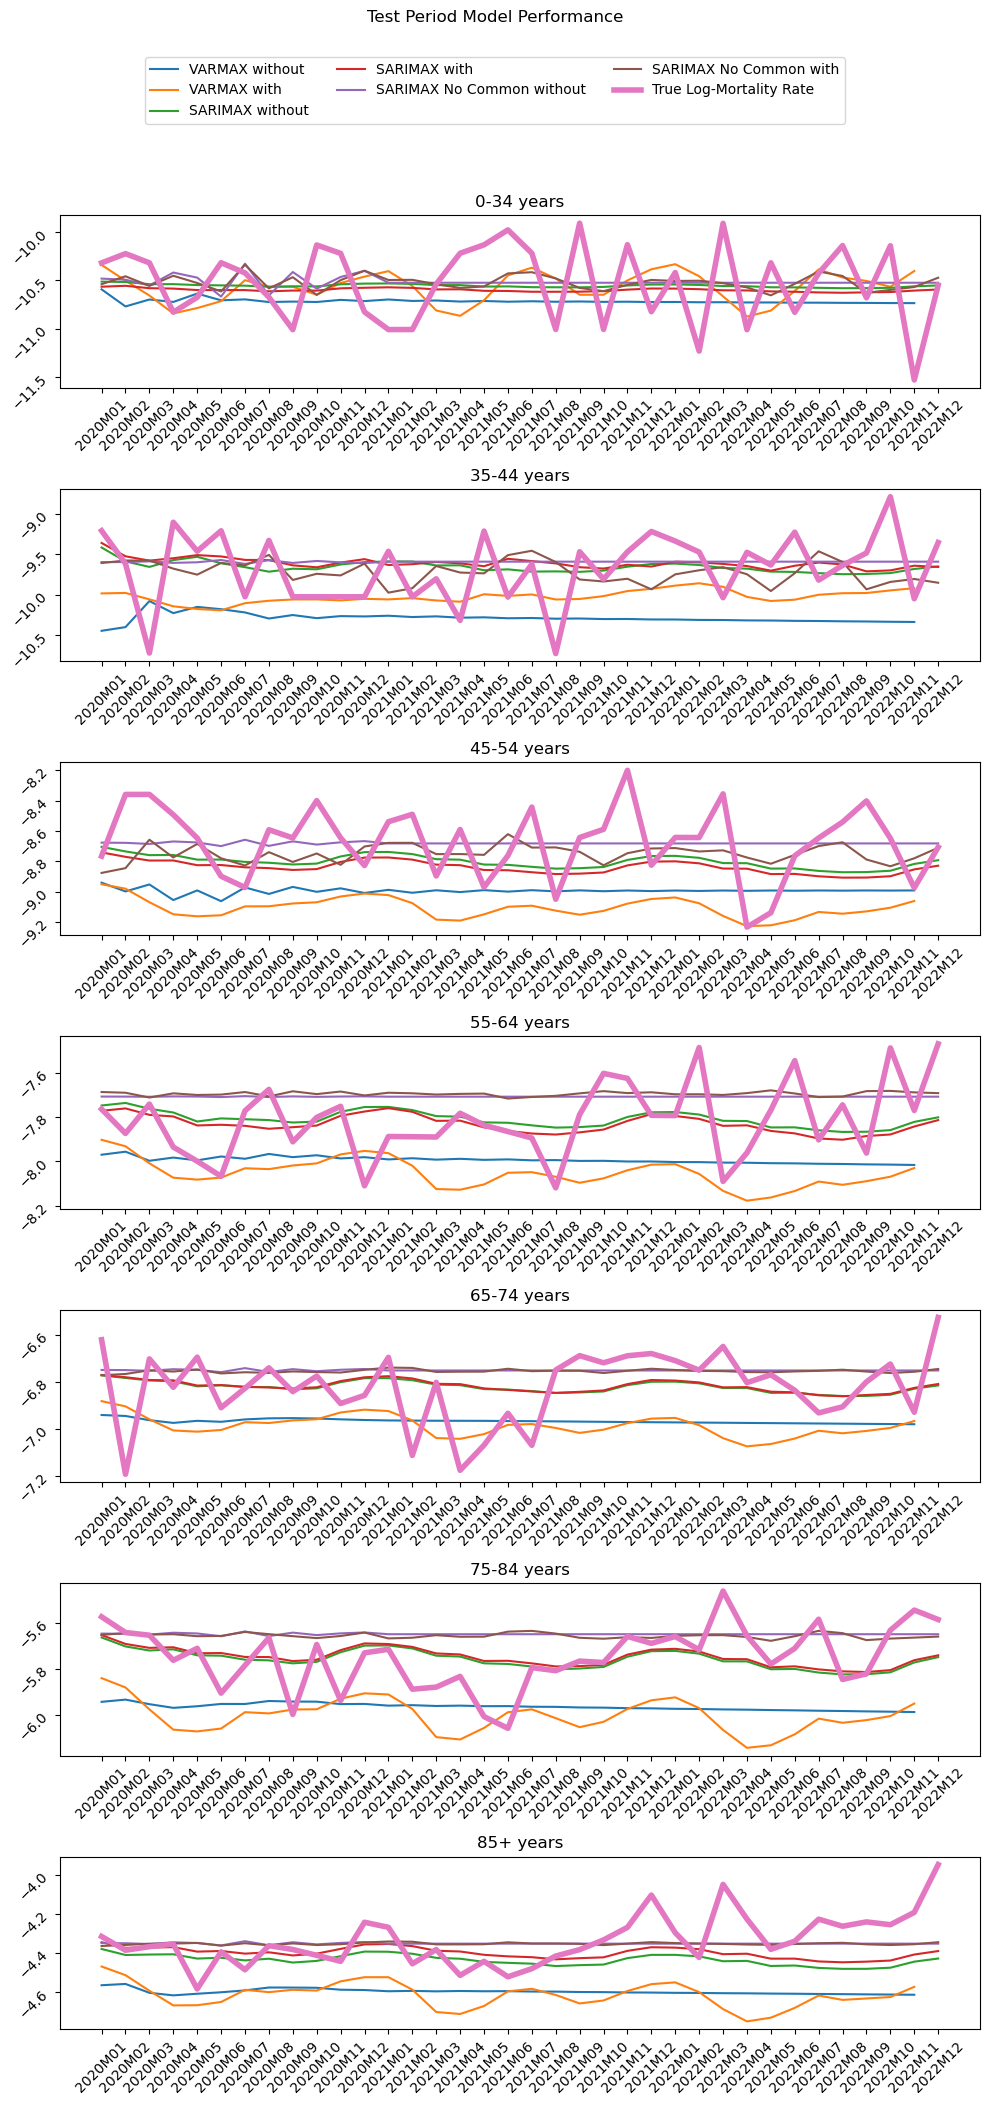

In [96]:
predictions_VAR_withCOVID = pd.DataFrame(predictions_VAR_withCOVID)
predictions_VAR_withCOVID.index = telemark_logmort_incCOVID.index
predictions_VAR_withCOVID.columns = telemark_logmort_incCOVID.columns

predictions_VAR_woutCOVID = pd.DataFrame(predictions_VAR_woutCOVID)
predictions_VAR_woutCOVID.index = telemark_logmort_incCOVID.index
predictions_VAR_woutCOVID.columns = telemark_logmort_incCOVID.columns


age_groups = telemark_logmort.index
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(10, 20))

# Store lines and labels to create a single legend
lines = []
labels = []

for row in range(7):
    age = age_groups[row]
    axes[row].set_title(age)
    
    line1, = axes[row].plot(predictions_VAR_woutCOVID.iloc[row, 84:], label="VARMAX without")
    line2, = axes[row].plot(predictions_VAR_withCOVID.iloc[row, 84:], label="VARMAX with")
    line3, = axes[row].plot(regional_predictions_saroutCOVID.iloc[row, 84:], label="SARIMAX without")
    line4, = axes[row].plot(regional_predictions_sarwithCOVID.iloc[row, 84:], label="SARIMAX with")
    line5, = axes[row].plot(regional_predictions_nocommoutCOVID.iloc[row, 84:], label="SARIMAX No Common without")
    line6, = axes[row].plot(regional_predictions_nocommwithCOVID.iloc[row, 84:], label="SARIMAX No Common with")
    line7, = axes[row].plot(telemark_logmort_incCOVID.iloc[row, 84:], label="True Log-Mortality Rate", linewidth=4)
    
    axes[row].tick_params(rotation=45)
    
    # Collect lines and labels for the legend
    if row == 0:
        lines.extend([line1, line2, line3, line4, line5, line6, line7])
        labels.extend([line.get_label() for line in lines])

# Create a single legend
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=3)
plt.suptitle("Test Period Model Performance", y=1.05)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

Note: year 7 is only half an epiyear!  + First 6 months disregarded
Note: year 8 is only half an epiyear!  + First 6 months disregarded


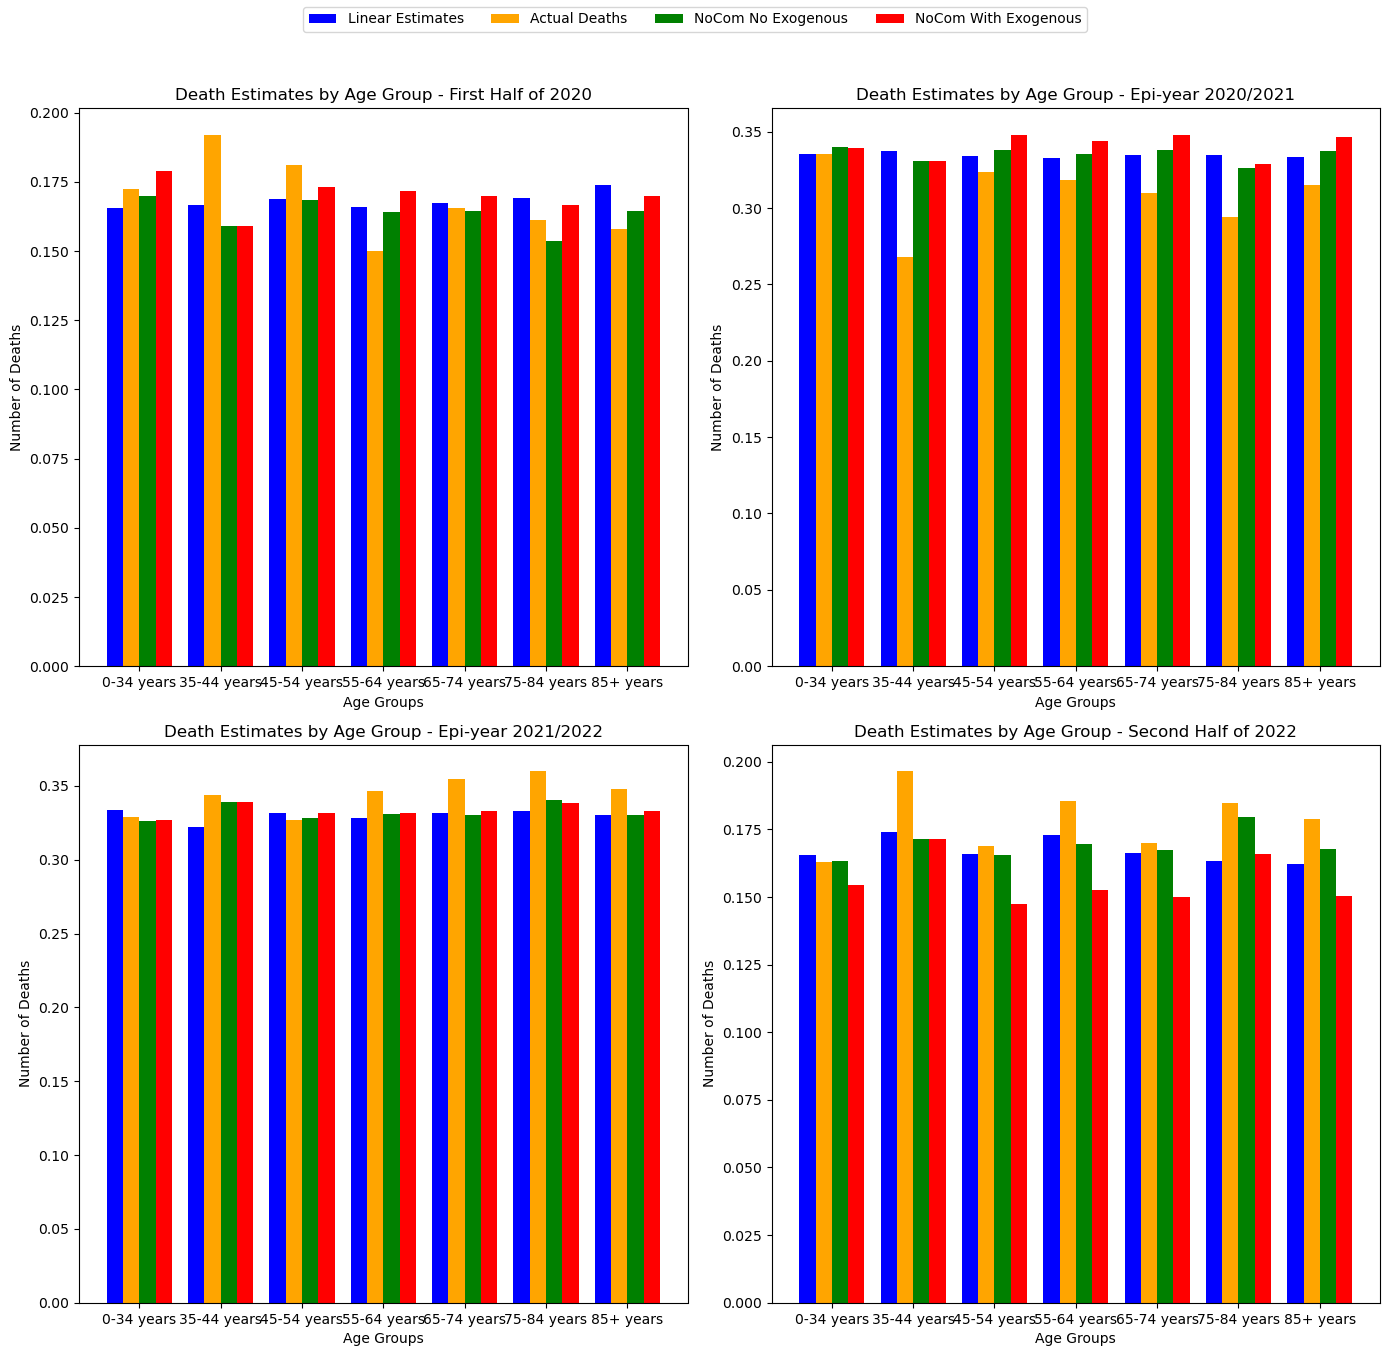

In [133]:
### Compile predictions for excess mortality for epidemic years
lin_ests_20 = np.round(est_half2_epiyear(telemark_death_COVID),0) #estimate for first 6 moths of 2020 ie. second half epi-year 19/20

#Use 2019/20 epi-year in estimate for epi-year 2020/21?  
lin_ests_20_21 = np.reshape(epi_year_lin_ests(pd.DataFrame(telemark_death_full.iloc[:,:96])),(7,))
lin_ests_21_22 = np.reshape(epi_year_lin_ests(pd.DataFrame(telemark_death_full.iloc[:,:108])),(7,))

#estimate for last 6 months of 2022 ie. first half epi-year 19/20
lin_ests_22 = np.round(est_half1_epiyear(telemark_death_COVID),0) #estimate for first 6 moths of 2020 ie. second half epi-year 19/20

# only first half of 2020, second half of epi-year 19/20
telemark_actual_deaths_20 = telemark_death_full.iloc[:,84:90].sum(axis = 1) 
telemark_actual_deaths_20_21 = epi_year(telemark_death_full.iloc[:,84:])["year_0"].sum(axis = 1)
telemark_actual_deaths_21_22 = epi_year(telemark_death_full.iloc[:,84:])["year_1"].sum(axis = 1)
telemark_actual_deaths_22 = epi_year(telemark_death_full.iloc[:,84:])["year_2"].sum(axis = 1) #only second half of 2022 


age_groups = telemark_logmort_full.index
r = np.arange(len(age_groups))
width = 0.2  # Adjusting width to fit four bars

fig, axes = plt.subplots(2, 2, figsize=(14, 14))  # Creating a 2x2 grid of subplots

# Labels for the legends
labels = ["Linear Estimates", "Actual Deaths", "NoCom No Exogenous", "NoCom With Exogenous"]

# Defining data sets for each subplot
data_sets = [
    (lin_ests_20, telemark_actual_deaths_20, telemark_NoCom_NoExog_deaths_20, telemark_NoCom_WithExog_deaths_20),
    (lin_ests_20_21, telemark_actual_deaths_20_21, telemark_NoCom_NoExog_deaths_20_21, telemark_NoCom_WithExog_deaths_20_21),
    (lin_ests_21_22, telemark_actual_deaths_21_22, telemark_NoCom_NoExog_deaths_21_22, telemark_NoCom_WithExog_deaths_21_22),
    (lin_ests_22, telemark_actual_deaths_22, telemark_NoCom_NoExog_deaths_22, telemark_NoCom_WithExog_deaths_22)
]
data_sets = data_sets/np.sum(data_sets,axis = 0)
titles = [
    'Death Estimates by Age Group - First Half of 2020',
    'Death Estimates by Age Group - Epi-year 2020/2021',
    'Death Estimates by Age Group - Epi-year 2021/2022',
    'Death Estimates by Age Group - Second Half of 2022'
]

for ax, data, title in zip(axes.flatten(), data_sets, titles):
    lin_est, actual_death, NoCom_noexog, NoCom_withexog = data
    ax.bar(r - 1.5*width, lin_est, width=width, align="center", color="blue", label=labels[0])
    ax.bar(r - 0.5*width, actual_death, width=width, align="center", color="orange", label=labels[1])
    ax.bar(r + 0.5*width, NoCom_noexog, width=width, align="center", color="green", label=labels[2])
    ax.bar(r + 1.5*width, NoCom_withexog, width=width, align="center", color="red", label=labels[3])
    ax.set_xticks(r)
    ax.set_xticklabels(age_groups)
    ax.set_xlabel('Age Groups')
    ax.set_ylabel('Number of Deaths')
    ax.set_title(title)

# Adding a single legend for the whole figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the legend
plt.show()






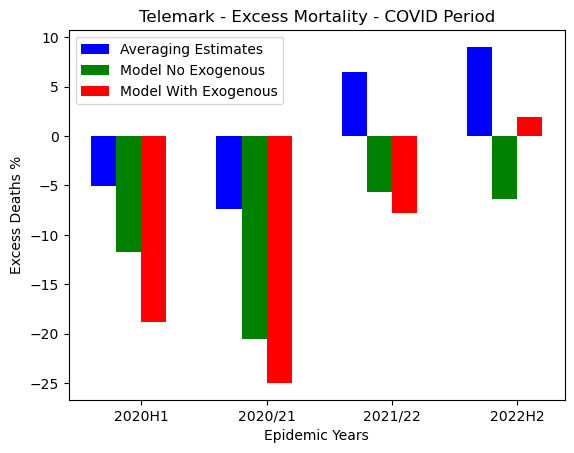

In [136]:


telemark_actual_deaths_total_20 = np.sum(telemark_actual_deaths_20)
lin_ests_excess_20 = (telemark_actual_deaths_total_20 - np.sum(lin_ests_20))/telemark_actual_deaths_total_20 *100
telemark_NoCom_NoExog_excess_total_20 = (telemark_actual_deaths_total_20 - np.sum(telemark_NoCom_NoExog_deaths_20))/telemark_actual_deaths_total_20 *100
telemark_NoCom_WithExog_excess_total_20 = (telemark_actual_deaths_total_20 - np.sum(telemark_NoCom_WithExog_deaths_20))/telemark_actual_deaths_total_20 *100

telemark_actual_deaths_total_20_21 = np.sum(telemark_actual_deaths_20_21)
lin_ests_excess_20_21 = (telemark_actual_deaths_total_20_21 - np.sum(lin_ests_20_21))/telemark_actual_deaths_total_20_21 *100
telemark_NoCom_NoExog_excess_total_20_21 = (telemark_actual_deaths_total_20_21 - np.sum(telemark_NoCom_NoExog_deaths_20_21))/telemark_actual_deaths_total_20_21 *100
telemark_NoCom_WithExog_excess_total_20_21 = (telemark_actual_deaths_total_20_21 - np.sum(telemark_NoCom_WithExog_deaths_20_21))/telemark_actual_deaths_total_20_21 *100

telemark_actual_deaths_total_21_22 = np.sum(telemark_actual_deaths_21_22)
lin_ests_excess_21_22 = (telemark_actual_deaths_total_21_22 - np.sum(lin_ests_21_22))/telemark_actual_deaths_total_21_22 *100
telemark_NoCom_NoExog_excess_total_21_22 = (telemark_actual_deaths_total_21_22 - np.sum(telemark_NoCom_NoExog_deaths_21_22))/telemark_actual_deaths_total_21_22 *100
telemark_NoCom_WithExog_excess_total_21_22 = (telemark_actual_deaths_total_21_22 - np.sum(telemark_NoCom_WithExog_deaths_21_22))/telemark_actual_deaths_total_21_22 *100

telemark_actual_deaths_total_22 = np.sum(telemark_actual_deaths_22)
lin_ests_excess_22 = (telemark_actual_deaths_total_22 - np.sum(lin_ests_22))/telemark_actual_deaths_total_22 *100
telemark_NoCom_NoExog_excess_total_22 = (telemark_actual_deaths_total_22 - np.sum(telemark_NoCom_NoExog_deaths_22))/telemark_actual_deaths_total_22 *100
telemark_NoCom_WithExog_excess_total_22 = (telemark_actual_deaths_total_22 - np.sum(telemark_NoCom_WithExog_deaths_22))/telemark_actual_deaths_total_22 *100


# Assuming telemark_logmort_full, lin_ests_20, telemark_actual_deaths_20, telemark_NoCom_NoExog_deaths_20, and telemark_NoCom_WithExog_deaths_20 are defined
# telemark_logmort_full.index should be a list or an array of age groups

years = ["2020H1", "2020/21","2021/22", "2022H2"]
r = np.arange(len(years))
width = 0.2  # Adjusting width to fit four bars

# Labels for the legends
labels = ["Averaging Estimates", "Model No Exogenous", "Model With Exogenous","_nolegend_"]

plt.bar(r[0] - 1.5*width, lin_ests_excess_20, width=0.2, align="center", color="blue", label=labels[0])
plt.bar(r[0] - 0.5*width, telemark_NoCom_NoExog_excess_total_20, width=0.2, align="center", color="green", label=labels[1])
plt.bar(r[0] + 0.5*width, telemark_NoCom_WithExog_excess_total_20, width=0.2, align="center", color="red", label=labels[2])
#plt.bar(r[0] + 1.5*width, telemark_actual_deaths_total_20, width=0.2, align="center", color="orange", label=labels[0])

plt.bar(r[1] - 1.5*width, lin_ests_excess_20_21, width=0.2, align="center", color="blue", label=labels[3])
plt.bar(r[1] - 0.5*width, telemark_NoCom_NoExog_excess_total_20_21, width=0.2, align="center", color="green", label=labels[3])
plt.bar(r[1] + 0.5*width, telemark_NoCom_WithExog_excess_total_20_21, width=0.2, align="center", color="red", label=labels[3])
#plt.bar(r[1] + 1.5*width, telemark_actual_deaths_total_20_21, width=0.2, align="center", color="orange", label=labels[0])

plt.bar(r[2] - 1.5*width, lin_ests_excess_21_22, width=0.2, align="center", color="blue", label=labels[3])
plt.bar(r[2] - 0.5*width, telemark_NoCom_NoExog_excess_total_21_22, width=0.2, align="center", color="green", label=labels[3])
plt.bar(r[2] + 0.5*width, telemark_NoCom_WithExog_excess_total_21_22, width=0.2, align="center", color="red", label=labels[3])

plt.bar(r[3] - 1.5*width, lin_ests_excess_22, width=0.2, align="center", color="blue", label=labels[3])
plt.bar(r[3] - 0.5*width, telemark_NoCom_NoExog_excess_total_22, width=0.2, align="center", color="green", label=labels[3])
plt.bar(r[3] + 0.5*width, telemark_NoCom_WithExog_excess_total_22, width=0.2, align="center", color="red", label=labels[3])

plt.xticks(r, years)
plt.legend()
plt.xlabel('Epidemic Years')
plt.ylabel('Excess Deaths %')
plt.title('Telemark - Excess Mortality - COVID Period');
# plt.show()



array([[9387327.        , 8778928.33333333, 9381416.33333333,
        9075930.        , 9375505.66666667, 9070210.        ,
        9369595.        , 9366639.66666667, 9061630.        ,
        9360729.        , 9055910.        , 9354818.33333333,
        9351863.        , 8445313.33333333, 9348473.66666667,
        9045270.        , 9345084.33333333, 9041990.        ,
        9341695.        , 9340000.33333333, 9037070.        ,
        9336611.        , 9033790.        , 9333221.66666667,
        9331527.        , 8433441.33333333, 9342521.66666667,
        9046470.        , 9353516.33333333, 9057110.        ,
        9364511.        , 9370008.33333333, 9073070.        ,
        9381003.        , 9083710.        , 9391997.66666667],
       [2793472.        , 2613603.25      , 2794231.5       ,
        2704462.5       , 2794991.        , 2705197.5       ,
        2795750.5       , 2796130.25      , 2706300.        ,
        2796889.75      , 2707035.        , 2797649.25      ,
       